In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
np.random.seed(123456)

import sys; sys.path.append("..")
from epimodel import EpidemiologicalParameters
from epimodel.pymc3_models.mask_models import RandomWalkMobilityModel, MandateMobilityModel
from epimodel.preprocessing.preprocess_mask_data import Preprocess_masks
import epimodel.viz.region_plot as rp
import epimodel.viz.prior_posterior as pp
import epimodel.viz.yougov as yg
import epimodel.viz.pred_cases as pc
import epimodel.viz.result_plot as rep
import epimodel.viz.mandate_wearing as mw
import epimodel.viz.empirical_wearing as ew

import calendar 
import theano.tensor as T
import theano.tensor.signal.conv as C
import theano

import pymc3 as pm
import pandas as pd
import copy
import re
import pickle
import datetime
from datetime import timedelta
import argparse
from pathlib import Path
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

import pickle 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import arviz as az
import json

sns.set(style="ticks", font='DejaVu Serif')
PNAS_WIDTH_INCHES = 3.4252

Set Theano Environmental Variables for Parallelisation


In [2]:
MODEL = "cases" #args.model
MASKS = "wearing" #args.masks
W_PAR = "exp" #args.w_par

n_mandates = 2

MOBI = 'include' # args.mob
US = True
SMOOTH = False
GATHERINGS = 3 #args.gatherings if args.gatherings else 3
# MASKING = True # Always true

if MODEL == "both":
    TUNING = 2500
else:
    TUNING = 2000

Ds = pd.date_range("2020-05-01", "2020-09-21", freq="D")

In [3]:
# prep data object

path = f"../data/modelling_set/master_data_mob_{MOBI}_us_{US}_m_w.csv"
masks_object = Preprocess_masks(path=path)

masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, n_mandates = 2)
masks_object.make_preprocessed_object()
data = masks_object.data

['C1_School closing', 'C1_School closing_full', 'C2_Workplace closing', 'C2_Workplace closing_full', 'C4_Restrictions on gatherings_3plus', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C4_Restrictions on gatherings_2plus', 'C4_Restrictions on gatherings_full', 'avg_mobility_no_parks_no_residential', 'percent_mc']
Masking May cases in US states
centering NPIs


In [4]:
# just mobility
path = "../data/modelling_set/master_data_mob_include_us_True_m_w.csv"
mobility_data = pd.read_csv(path)
mobility_data = mobility_data.set_index(["country", "date"])



In [5]:
def load_oxcgrt(use_us=True):
    OXCGRT_PATH = "../data/raw/OxCGRT_latest.csv"
    oxcgrt = pd.read_csv(OXCGRT_PATH, parse_dates=["Date"], low_memory=False)
    # Drop regional data
    nat = oxcgrt[oxcgrt.Jurisdiction == "NAT_TOTAL"]

    # Add US states
    if use_us:
        states = oxcgrt[
            (oxcgrt.CountryName == "United States")
            & (oxcgrt.Jurisdiction == "STATE_TOTAL")
        ]
        # Drop GEO to prevent name collision
        nat = nat[nat.CountryName != "Georgia"]
        states.CountryName = states.RegionName
        states = states.replace("Georgia", "Georgia-US")
        nat = pd.concat([nat, states])

    i = list(nat.columns).index("Date")
    nat.columns = list(nat.columns[:i]) + ["date"] + list(nat.columns[i + 1 :])

    return nat[nat.date.isin(Ds)]


maxes = {
    "C1": 3, 
    "C2": 3, 
    "C3": 2, 
    "C4": 4, 
    "C5": 2, 
    "C6": 3, 
    "C7": 2, 
    "C8": 4, 
    "H1": 2
}

def subindex(df, c) :
    x = df[c] - 0.5 * (1 - df[c[:2] + "_Flag"] )
    return (x / maxes[c[:2]]) * 100


# now with no weight on regional
def nat_subindex(df, c) :
    x = df[c] * df[c[:2] + "_Flag"] 
    return (x / maxes[c[:2]]) * 100

# https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/index_methodology.md
def stringency(data, national=True):
    if national: 
        sub = nat_subindex
    else :
        sub = subindex
    
    df = data.copy()
    new_stringency_codes = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "H1"]
    nonflags = [c for c in data.columns if "Flag" not in c]
    new_stringency_cols = [c for c in nonflags if c[:2] in new_stringency_codes]
    
    for c in new_stringency_cols:
        if c[:2] != "C8":
            df[c] = sub(df, c)
        else :
            df[c] = df[c] / maxes[c[:2]] * 100
    
    return df[new_stringency_cols].mean(axis=1).round(2)


oxcgrt = load_oxcgrt()
oxcgrt = oxcgrt[oxcgrt.date.isin(Ds)]
oxcgrt["StringencyIndexNational"] = stringency(oxcgrt)

In [6]:
# https://rt.live/

def load_rts() :
    third_party_rts_us = pd.read_csv("../data/raw/us_rt_live.csv", parse_dates=["date"])
    third_party_rts_us
    us_state_abbrev = {    'Alabama': 'AL',    'Alaska': 'AK',    'American Samoa': 'AS',    'Arizona': 'AZ',    'Arkansas': 'AR',    'California': 'CA',    'Colorado': 'CO',    'Connecticut': 'CT',    'Delaware': 'DE',    'District of Columbia': 'DC',    'Florida': 'FL',    'Georgia': 'GA',    'Guam': 'GU',    'Hawaii': 'HI',    'Idaho': 'ID',    'Illinois': 'IL',    'Indiana': 'IN',    'Iowa': 'IA',    'Kansas': 'KS',    'Kentucky': 'KY',    'Louisiana': 'LA',    'Maine': 'ME',    'Maryland': 'MD',    'Massachusetts': 'MA',    'Michigan': 'MI',    'Minnesota': 'MN',    'Mississippi': 'MS',    'Missouri': 'MO',    'Montana': 'MT',    'Nebraska': 'NE',    'Nevada': 'NV',    'New Hampshire': 'NH',    'New Jersey': 'NJ',    'New Mexico': 'NM',    'New York': 'NY',    'North Carolina': 'NC',    'North Dakota': 'ND',    'Northern Mariana Islands':'MP',    'Ohio': 'OH',    'Oklahoma': 'OK',    'Oregon': 'OR',    'Pennsylvania': 'PA',    'Puerto Rico': 'PR',    'Rhode Island': 'RI',    'South Carolina': 'SC',    'South Dakota': 'SD',    'Tennessee': 'TN',    'Texas': 'TX',    'Utah': 'UT',    'Vermont': 'VT',    'Virgin Islands': 'VI',    'Virginia': 'VA',    'Washington': 'WA',    'West Virginia': 'WV',    'Wisconsin': 'WI',    'Wyoming': 'WY'}
    us_state_abbrev = {value:key for key, value in us_state_abbrev.items()}
    third_party_rts_us.region = third_party_rts_us.region.replace(us_state_abbrev)
    third_party_rts_us.region = third_party_rts_us.region.replace({"Georgia": "Georgia-US"})
    cols = ['date', 'region', 'mean', 'lower_80', 'upper_80']
    third_party_rts_us = third_party_rts_us[cols]

    # http://epidemicforecasting.org/country-rt-estimates
    epifor_rts = pd.read_csv("../data/raw/r_estimates_epifor.csv", parse_dates=["Date"])
    epifor_rts = epifor_rts[epifor_rts.EnoughData == 1]
    epifor_rts = epifor_rts[epifor_rts.Date.isin(Ds)]
    epifor_rts.Date = epifor_rts.Date.dt.date #pd.to_datetime(epifor_rts.Date, utc=True)

    def recode(epifor_rts) :
        with open("../data/raw/3166.json") as f:
            codes = json.load(f)
            codes = codes['3166-1']

        a2 = [c.get("alpha_2") for c in codes]
        names = [c.get("name") for c in codes]
        map_ = {c: n for c, n in zip(a2, names)}
        epifor_rts["region"] = epifor_rts.Code
        epifor_rts.region = epifor_rts.Code.replace(map_)
        epifor_rts.region = epifor_rts.region.replace({"Tanzania, United Republic of": "Tanzania"})
        epifor_rts.region = epifor_rts.region.replace({"Viet Nam": "Vietnam"})
        epifor_rts.region = epifor_rts.region.replace({"Korea, Republic of": "South Korea"})

        return epifor_rts

    epifor_rts = recode(epifor_rts)
    epifor_rts.columns = ["code", "date", "mean", "std", "enough", "region"]

    z80 = 0.842
    epifor_rts["lower_80"] = epifor_rts["mean"] - z80 * epifor_rts["std"]
    epifor_rts["upper_80"] = epifor_rts["mean"] + z80 * epifor_rts["std"]
    #epifor_rts = epifor_rts[cols]
    third_party_rts = pd.concat([epifor_rts, third_party_rts_us])
    
    # Correct for absence of case delay in Epifor
    third_party_rts["mean_minus10"] = third_party_rts["mean"].shift(-10)
    third_party_rts.date = pd.to_datetime(third_party_rts.date)
    
    return third_party_rts


third_party_rts = load_rts()

# What's the empirical Rt?

In [7]:
relevant = third_party_rts[third_party_rts.date.isin(Ds)]
relevant = relevant[relevant.region.isin(data.Rs)]
relevant["mean_minus10"].mean(), relevant["mean_minus10"].std()

(1.0740244423285863, 0.3236054496092173)

In [8]:
print("How many regions?:", len(data.Rs))
print("How many NPIs?:", len(data.CMs))
print("How many days?:", len(data.Ds))

How many regions?: 92
How many NPIs?: 11
How many days?: 144


# Load pickle

In [9]:
mandate_pkl_5pct = "mandate_2and3_cases_countries_92_05-28-16:44.pkl"
mandate_pkl_0 = "mandate_2and3_cases_countries_92_06-04-16:37.pkl"
q2_pkl_1000_250 = "zeroed_wearing_hyper_Rs_wearing_log_quadratic_2_cases_countries_92_05-25-18:37.pkl"
exp_pkl = "wearing_exp_cases_countries_92_05-31-02:56.pkl" # 1000 + 700 
ll_pkl = "wearing_log_linear_cases_countries_92_06-05-16:46.pkl"


def load_pickle(p) :
    path = 'pickles/' + p
    with open(path, 'rb') as buff:
        trace = pickle.load(buff)

    colfile = path[:-4] + "_cols"
    
    cf = Path(colfile)
    if cf.is_file():
        with open(colfile, "r") as f:
            npi_cols = f.read().split(", ")
    else :
        print("cols missing")
        npi_cols = []
    
    return trace, npi_cols


m_trace, _ = load_pickle(mandate_pkl_0)
exp_trace, npi_cols = load_pickle(exp_pkl)
#q2_trace, npi_cols = load_pickle(q2_pkl_1000_250)
#ll_trace, _ = load_pickle(ll_pkl)

print("Pickle has", exp_trace.RegionR.shape[1], "regions")




varnames = [c for c in exp_trace.varnames if c not in ["Psi_log__", "Infected_log", "HyperRVar_log__", "GrowthNoiseScale_log__", "r_walk_noise_scale_log__"]]
#varnames

Pickle has 92 regions


In [10]:
trace = exp_trace

# Main result

In [11]:
1 - np.median(exp_trace.WearingReduction)

0.25088663842268377

In [12]:
#ns = npi_cols.copy()

v = ["CMReduction"]
if "WearingReduction" in m_trace.varnames :
    v += ["WearingReduction"]
if "MandateReduction" in m_trace.varnames :
    v += ["MandateReduction"]
if "MobilityReduction" in m_trace.varnames :
    v += ["MobilityReduction"]
    #ns.remove("avg_mobility_no_parks_no_residential")
    #ns += ["MobilityReduction"]


s = pm.summary(m_trace, var_names=v, hdi_prob=0.95)
#s.index = ns
s

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
CMReduction[0]        0.985  0.045     0.895      1.073      0.001    0.001   
CMReduction[1]        0.968  0.042     0.877      1.047      0.001    0.001   
CMReduction[2]        0.977  0.032     0.916      1.035      0.001    0.001   
CMReduction[3]        0.934  0.048     0.839      1.022      0.002    0.001   
CMReduction[4]        0.970  0.045     0.878      1.053      0.001    0.001   
CMReduction[5]        0.995  0.035     0.923      1.060      0.001    0.001   
CMReduction[6]        0.997  0.039     0.921      1.079      0.001    0.001   
CMReduction[7]        1.060  0.060     0.960      1.187      0.002    0.001   
CMReduction[8]        0.981  0.039     0.902      1.052      0.001    0.001   
MandateReduction[0]   1.006  0.045     0.918      1.088      0.002    0.001   
MobilityReduction[0]  0.597  0.095     0.424      0.788      0.004    0.003   

                      ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
CMReduction[0]          1182.0  1182.0    1208.0     816.0   1.00  
CMReduction[1]          1152.0  1152.0    1171.0     718.0   1.00  
CMReduction[2]          1160.0  1160.0    1170.0     696.0   1.01  
CMReduction[3]           608.0   608.0     641.0     691.0   1.00  
CMReduction[4]          1345.0  1345.0    1387.0     728.0   1.00  
CMReduction[5]           636.0   634.0     642.0     748.0   1.00  
CMReduction[6]           987.0   974.0    1073.0     800.0   1.00  
CMReduction[7]          1044.0  1020.0    1131.0     788.0   1.00  
CMReduction[8]           962.0   962.0     971.0     758.0   1.00  
MandateReduction[0]      764.0   764.0     746.0     505.0   1.00  
MobilityReduction[0]     611.0   611.0     610.0     796.0   1.00

# Significance as AUC

In [13]:
def p(samples) :
    return 1 - np.sum(samples < 1) / len(samples)

p(exp_trace.WearingReduction), p(m_trace.MandateReduction)

(0.010000000000000009, 0.546)

In [14]:
def plot_posterior_renamed() :
    plots = pm.plots.plot_posterior(trace, var_names=["WearingReduction", "MobilityReduction"], hdi_prob=0.95)
    n = npi_cols
#     for i, p in enumerate(plots):
#         p.set_title(n[i])

    plt.show()
    
# plot_posterior_renamed()

In [15]:
import arviz as az
ess = az.ess(exp_trace)
rhat = az.rhat(exp_trace)

<ipython-input-16-9d9e1b3de738>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  stat_all = np.concatenate(np.array(stat_all))
<ipython-input-16-9d9e1b3de738>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(ylabels)


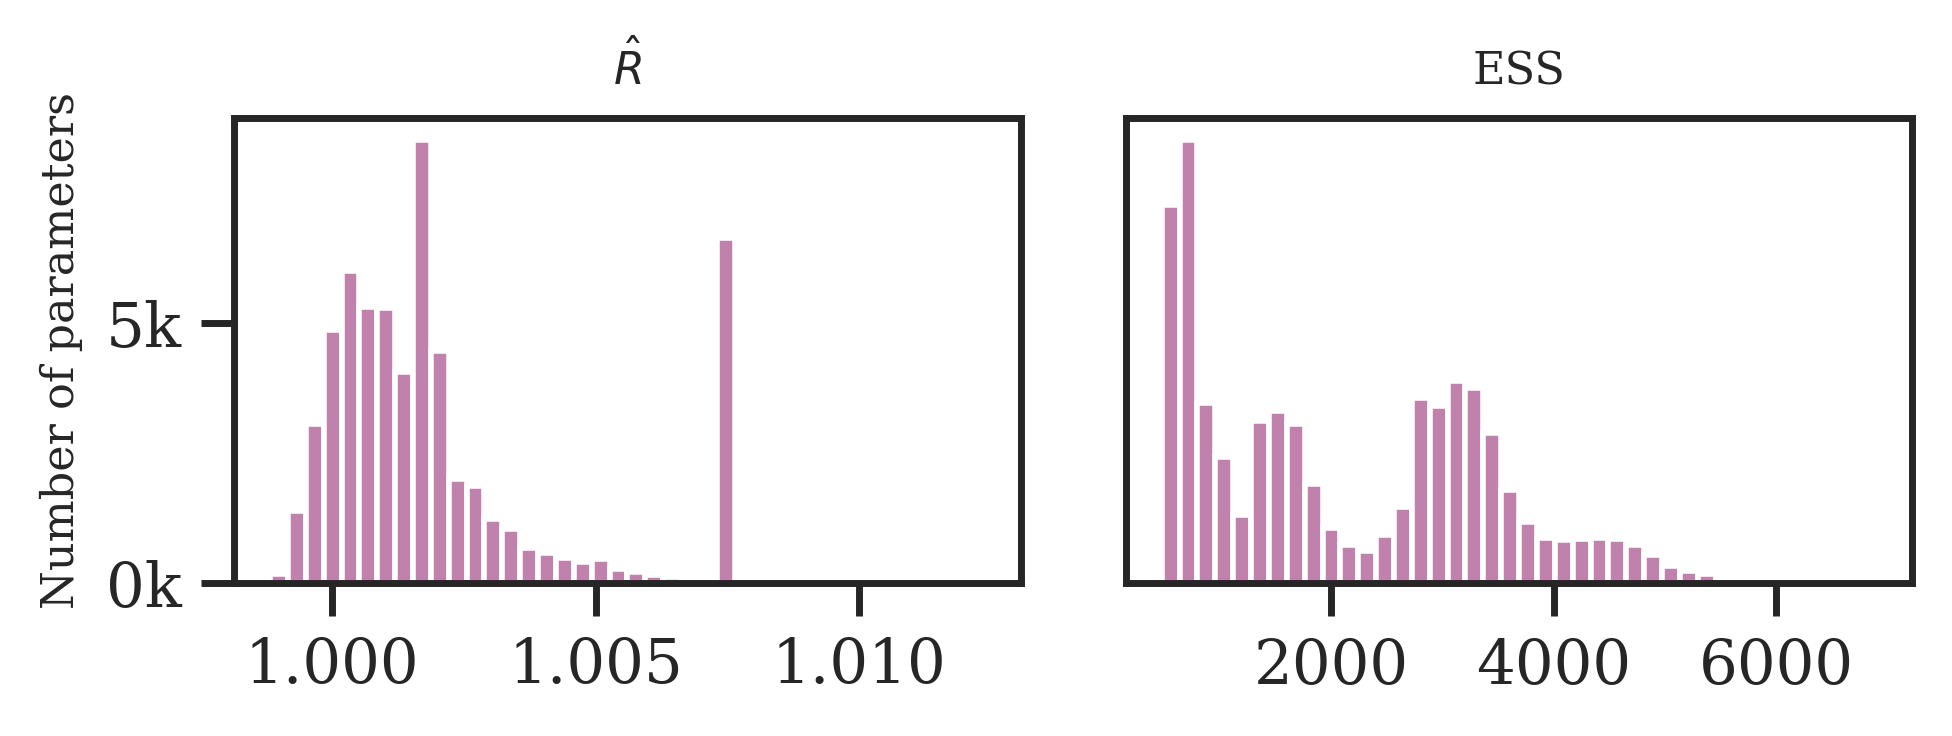

In [16]:
vs_minus_logs = [v for v in varnames if v not in ["r_walk_noise_scale_log__", "HyperRMean_lowerbound__"]]


def collate(stat, varnames):
    stat_all = []
    stat_nums = []
    for var in varnames :
        if stat[str(var)].size > 1:
            stat_all.append(stat[str(var)].to_dataframe().to_numpy().flatten())
        else:
            stat_nums.append(float(stat[str(var)]))
    stat_all = np.concatenate(np.array(stat_all))
    stat_all = np.concatenate([stat_all, stat_nums])
    # stat_all[stat_all > 100] = 1
    return stat_all

def diagnostics(tr) :
    for r in tr.varnames :
        rhat = pm.rhat(tr)[r]
        print(f'Rhat({r}) = {rhat}')

cols = sns.cubehelix_palette(3, start=0.2, light=0.6, dark=0.1, rot=0.2)

PNAS_WIDTH_INCHES = 3.4252
plt.figure(figsize=(PNAS_WIDTH_INCHES * 1.5, 2), dpi=400)
plt.subplot(121)
plt.hist(collate(rhat, vs_minus_logs), bins=40, color=cols[0])
plt.title("$\hat{R}$", fontsize=8)
ylabels = ['{:,.0f}'.format(x) + 'k' for x in plt.gca().axes.get_yticks()/1000]
plt.gca().set_yticklabels(ylabels)
plt.ylabel("Number of parameters", fontsize=8)

def get_total_samples(t) :
    l = str(t).replace("<MultiTrace: ", "").split(",")
    return int(l[0].split()[0]) * int(l[1].split()[0])


plt.subplot(122)
plt.hist(collate(ess, vs_minus_logs), bins=40, color=cols[0]) # / samples
#plt.xlim() # [0,2] 
plt.gca().axes.get_yaxis().set_visible(False)
plt.title("ESS", fontsize=8) 
plt.tight_layout()

plt.savefig("../outputs/mcmc_wearing.pdf", bbox_inches="tight")


# Prior / posterior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [HyperRMean]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.90087834660476, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912181107392884, but should be close to 0.8. Try to increase the number of tuning steps.
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5827769467156053, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [HyperRVar]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_walk_noise_scale]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GI_mean]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GI_sd]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Psi]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


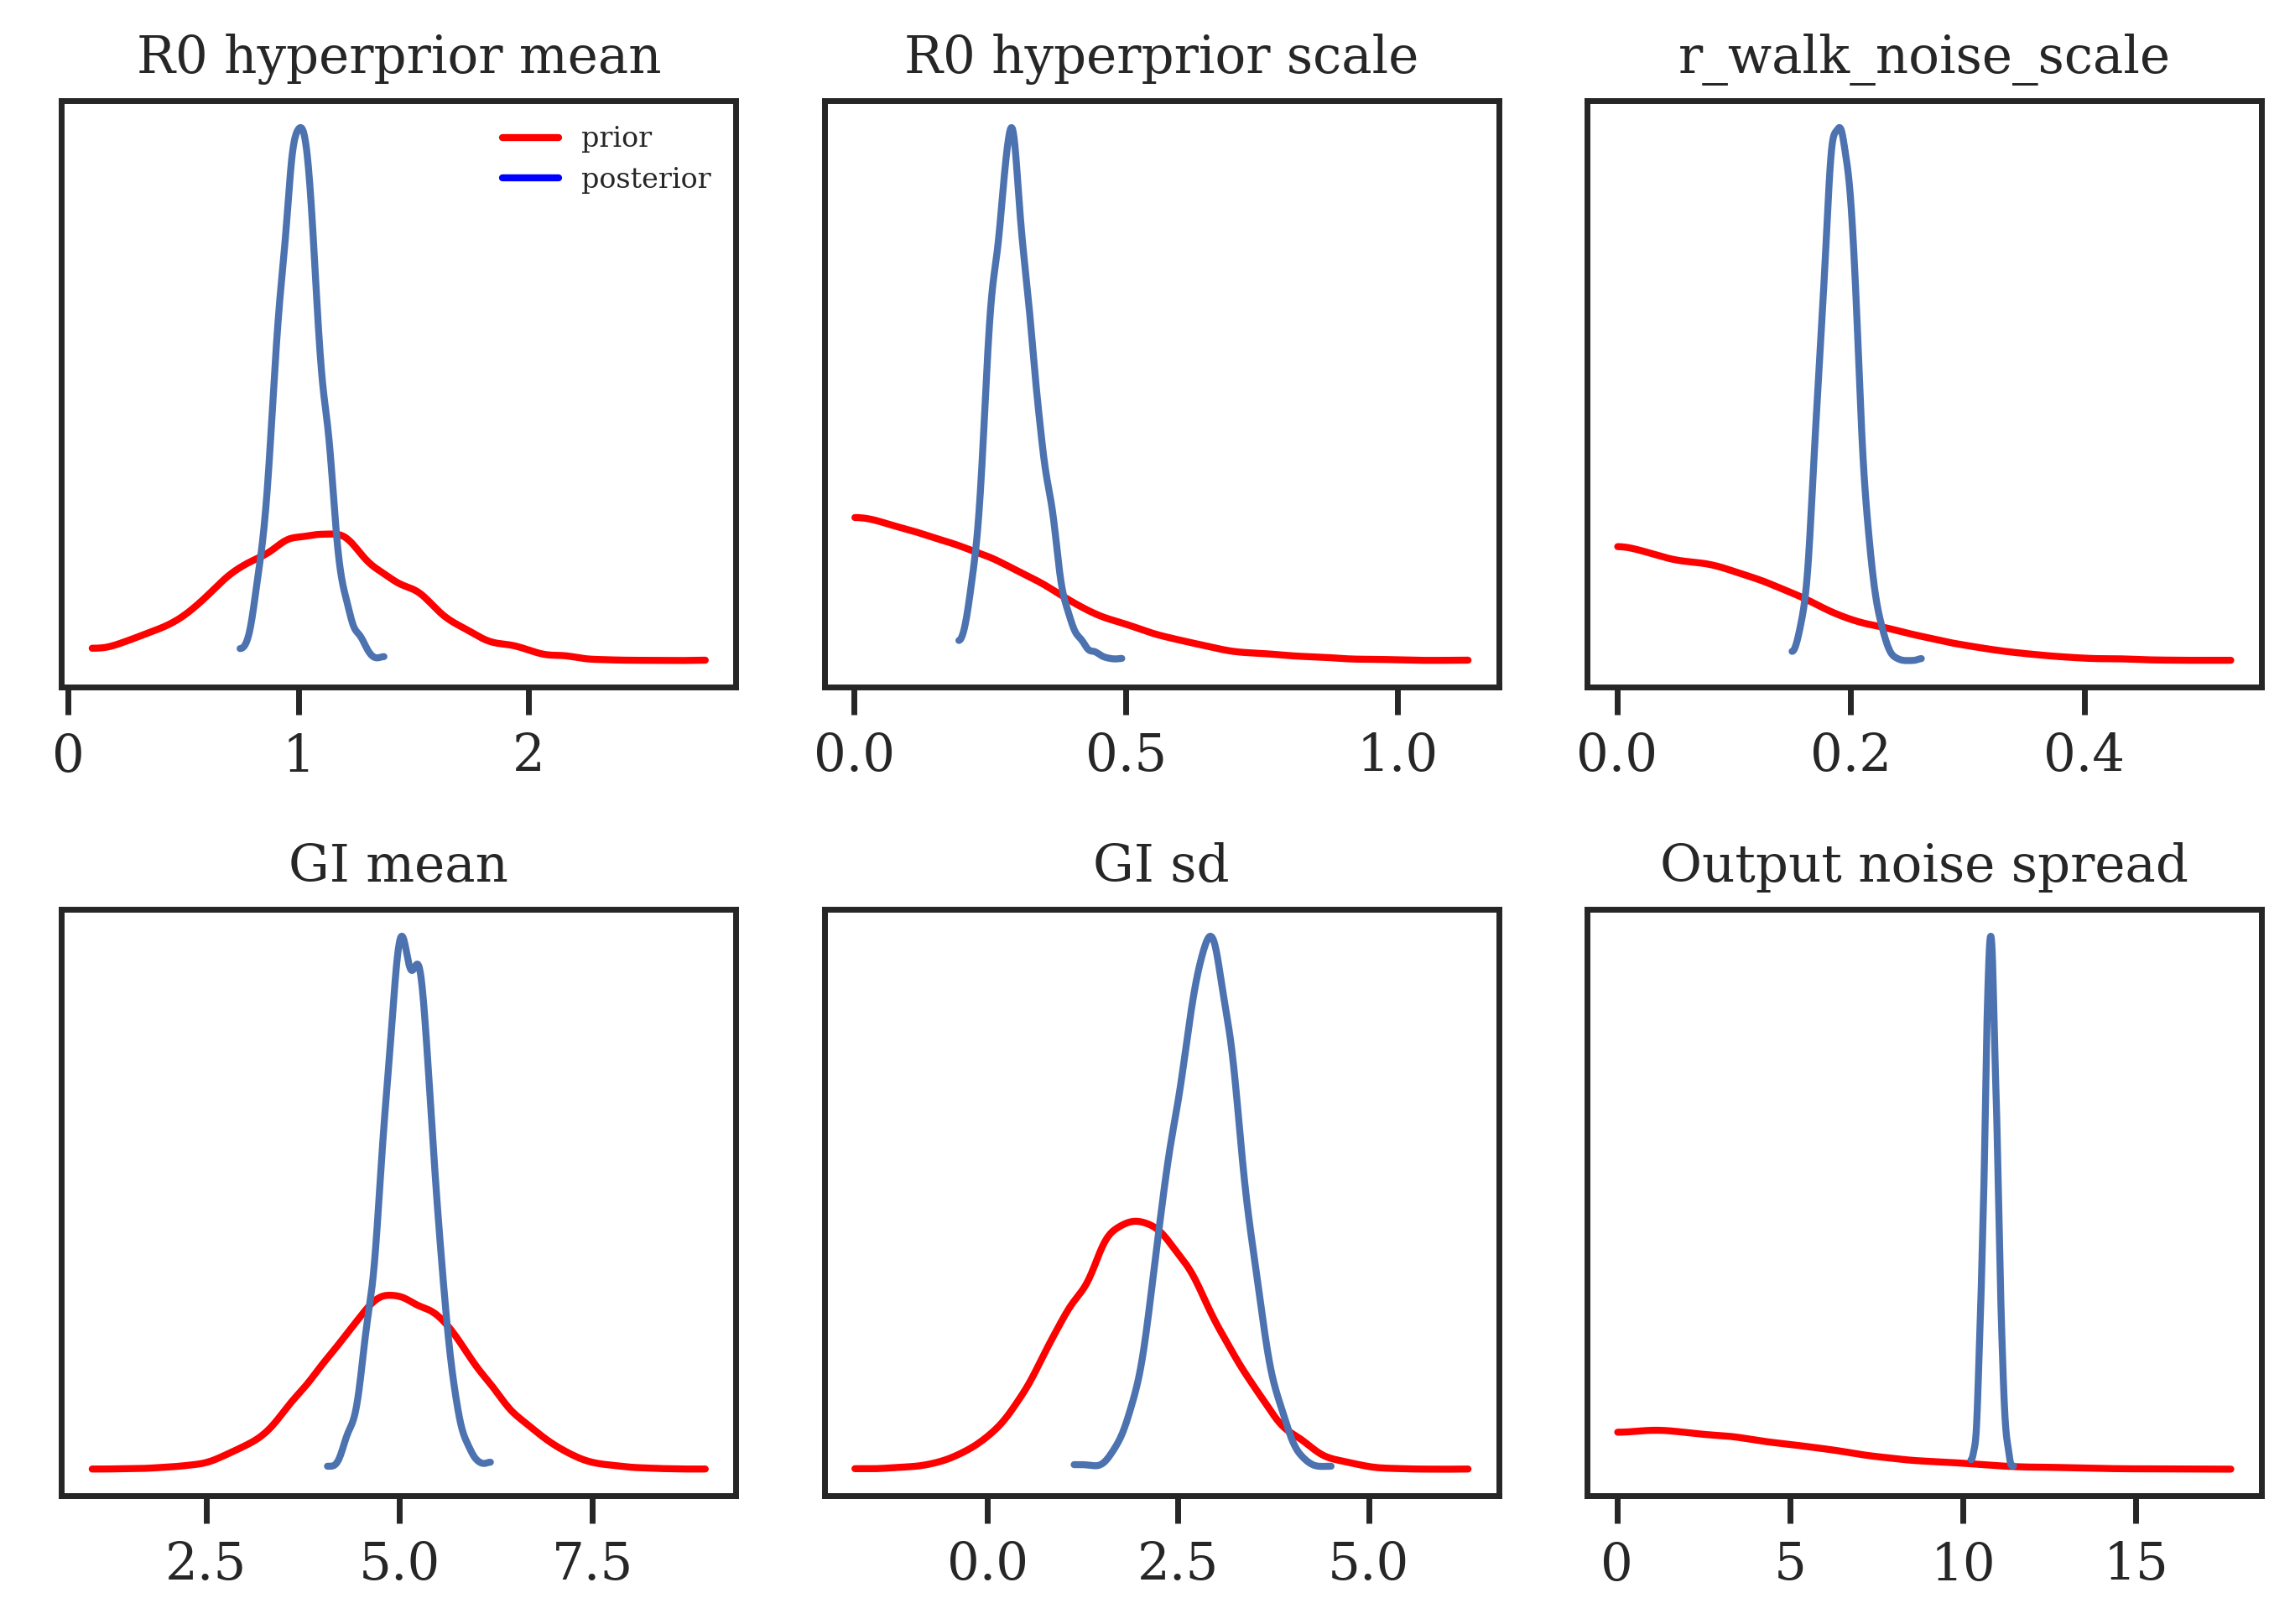

In [17]:
import imp
imp.reload(pp)
pp.plot_all_pps(exp_trace, m_trace)
plt.tight_layout()
plt.savefig(f"../outputs/pp_grid.pdf", bbox_inches="tight")

# Fits and holdouts

/mnt/c/Users/techn/code/masks_v_mandates/epimodel/viz/pred_cases.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["May", "Jun", "Jul", "Aug", "Sep"])


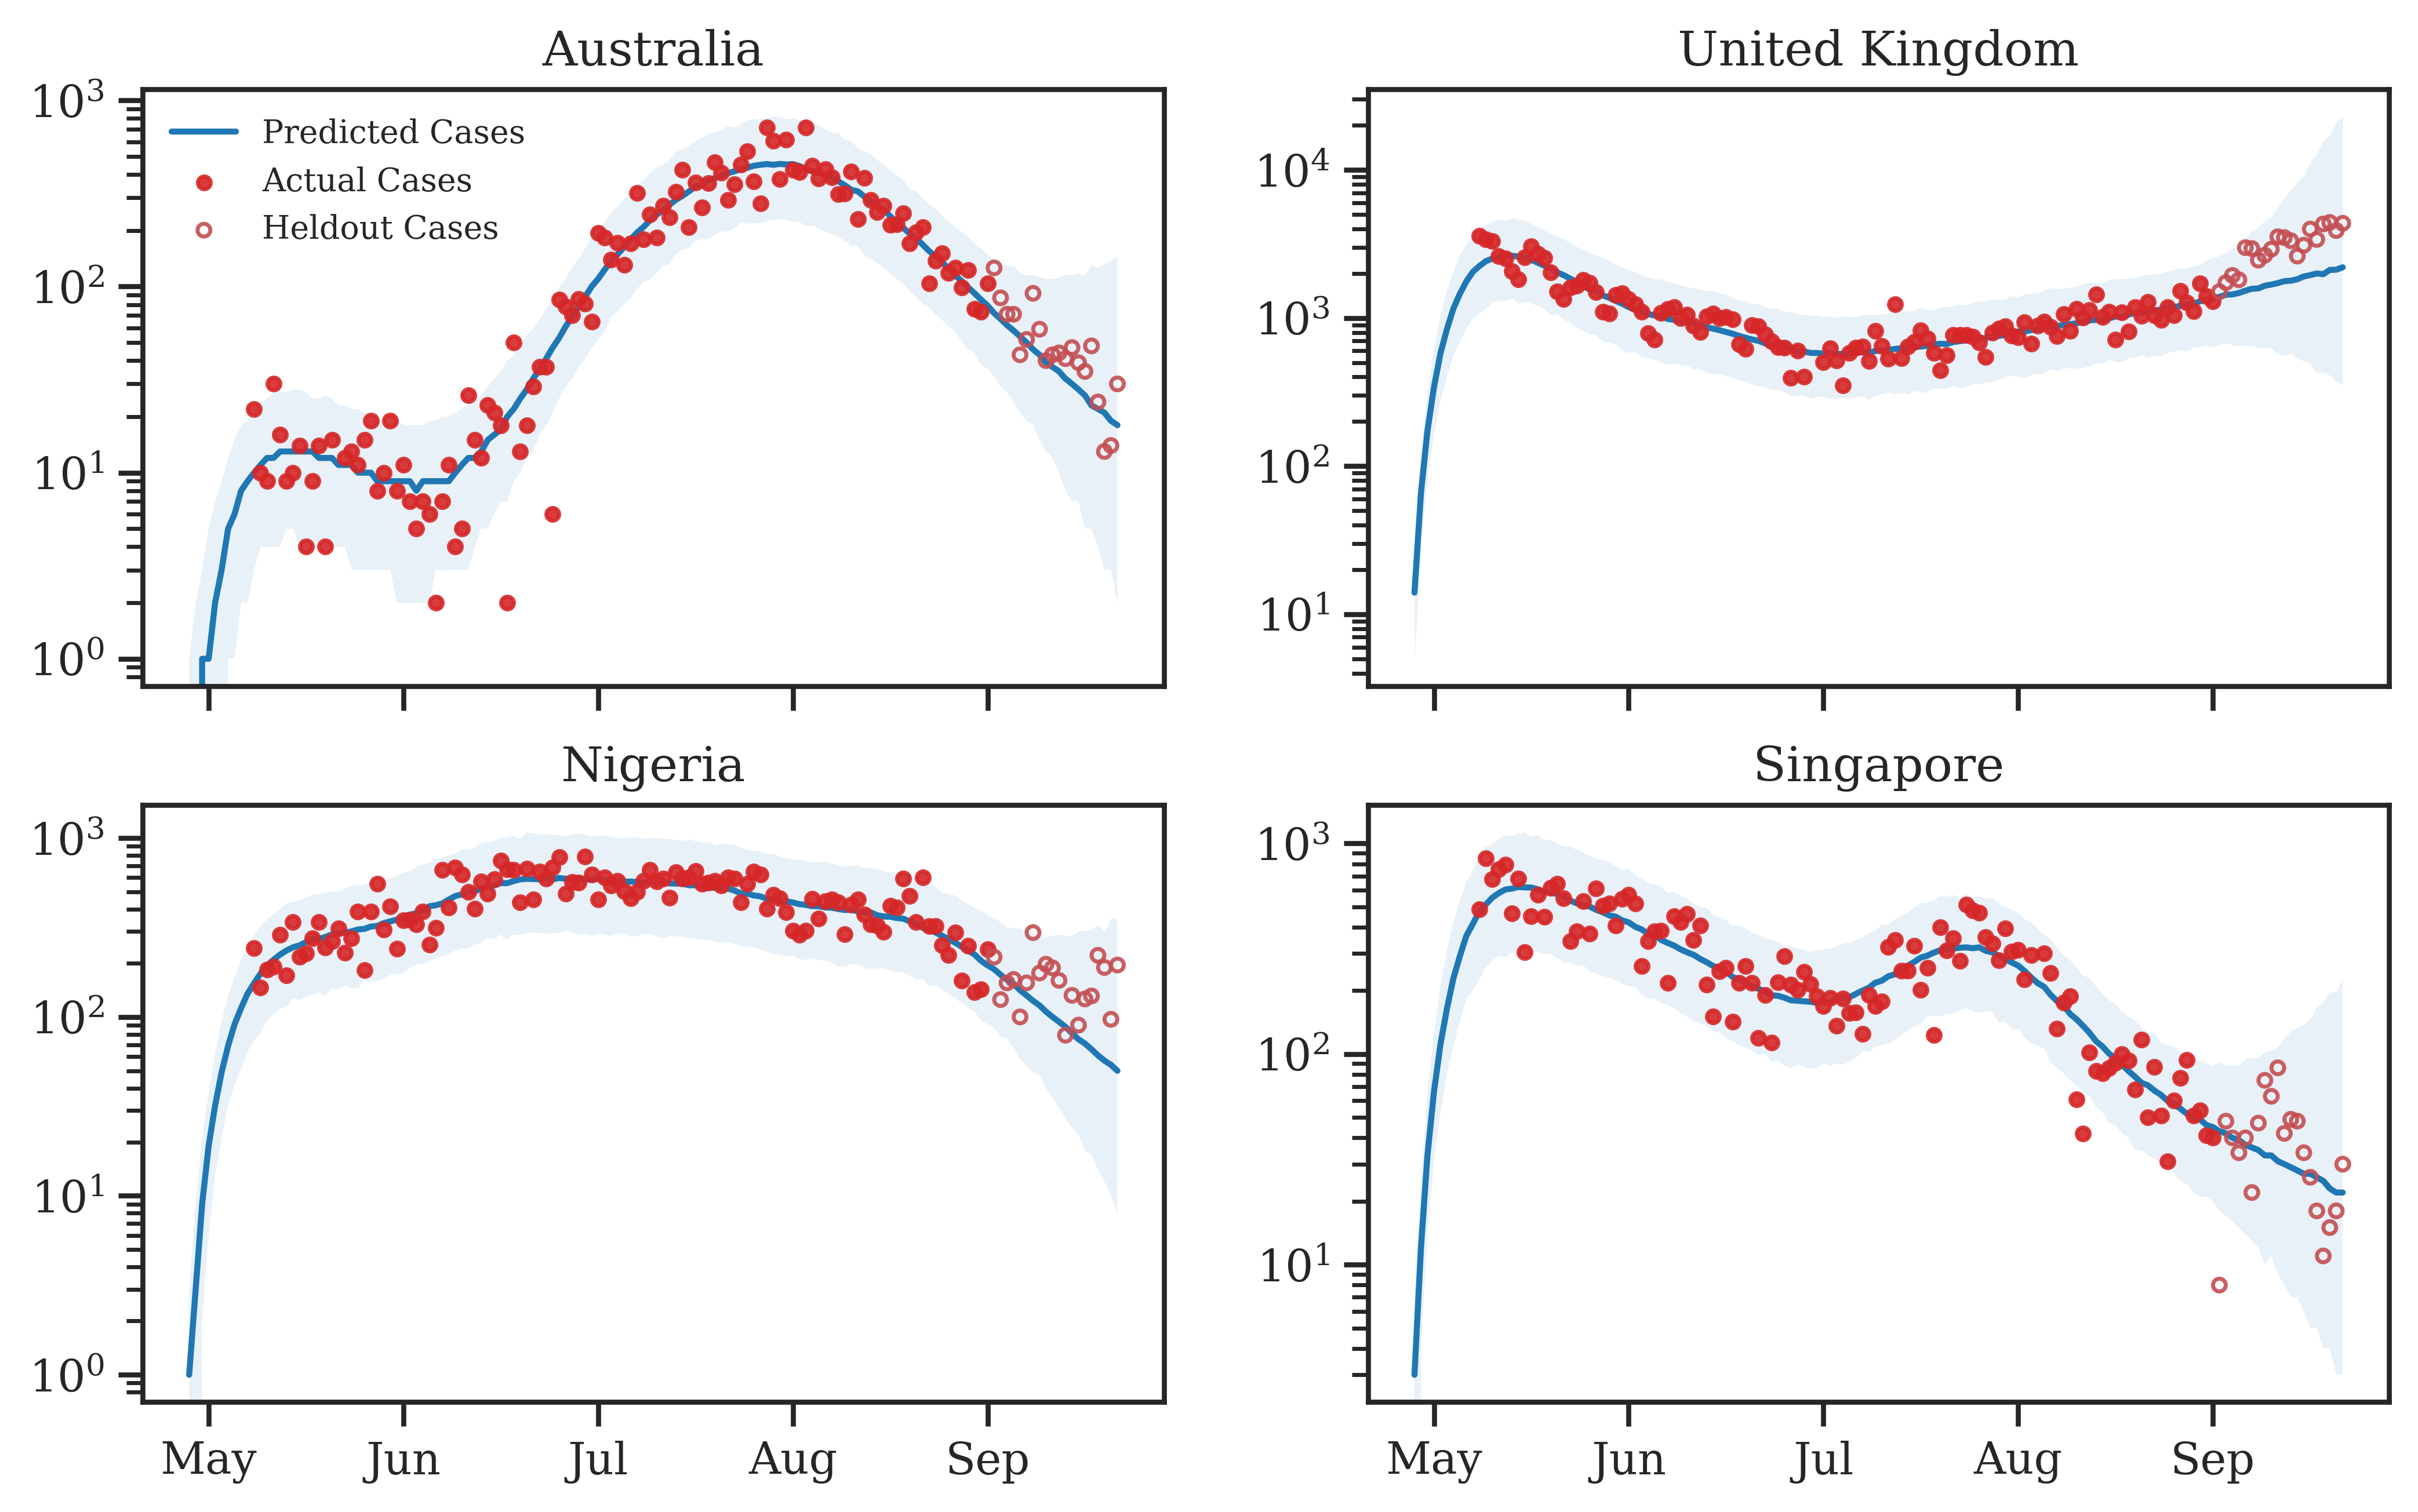

In [18]:
imp.reload(pc)

# for region in data.Rs :
#     pc.epicurve_plot(data, oxcgrt, trace, region)


    
pred_rs = ["Australia", "United Kingdom", "Nigeria", "Singapore"] 
f, (rowax, colax) = plt.subplots(2, 2, figsize=(10,6), dpi=500, sharex=True)
pc.epicurve_plot(data, oxcgrt, Ds, exp_trace, pred_rs[0], rowax[0], leg=True)
pc.epicurve_plot(data, oxcgrt,  Ds, exp_trace, pred_rs[1], rowax[1])
pc.epicurve_plot(data, oxcgrt,  Ds, exp_trace, pred_rs[2], colax[0])
pc.epicurve_plot(data, oxcgrt,  Ds, exp_trace, pred_rs[3], colax[1])


plt.savefig(f"../outputs/pred_curves_4.pdf", bbox_inches="tight")

# Key Panels

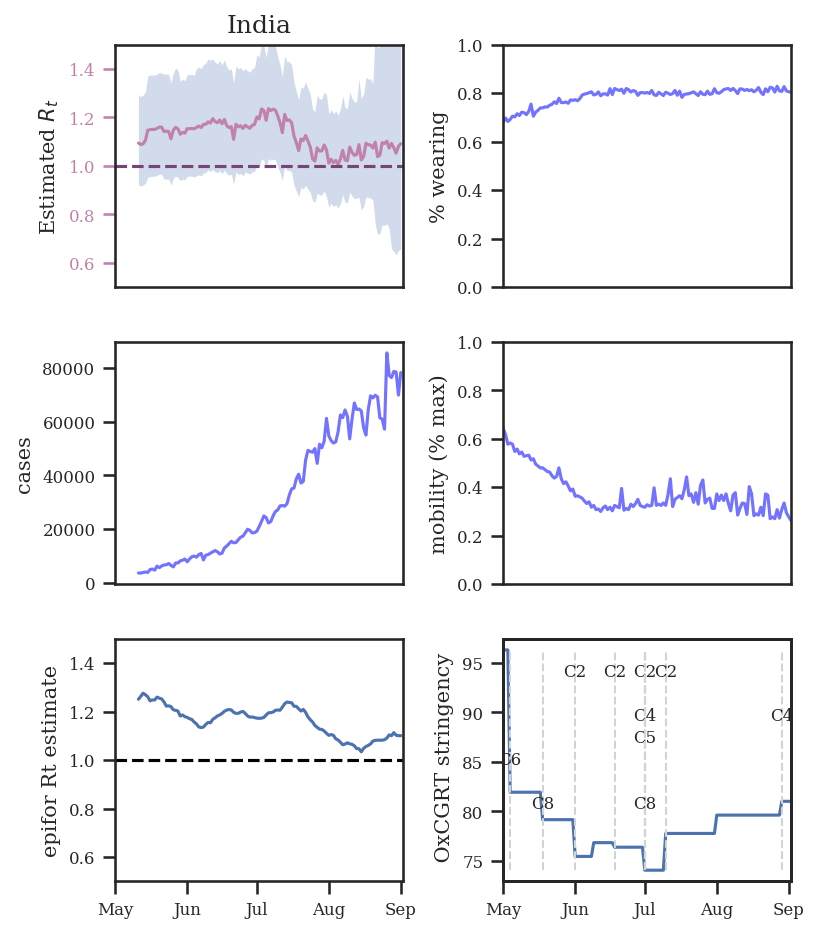

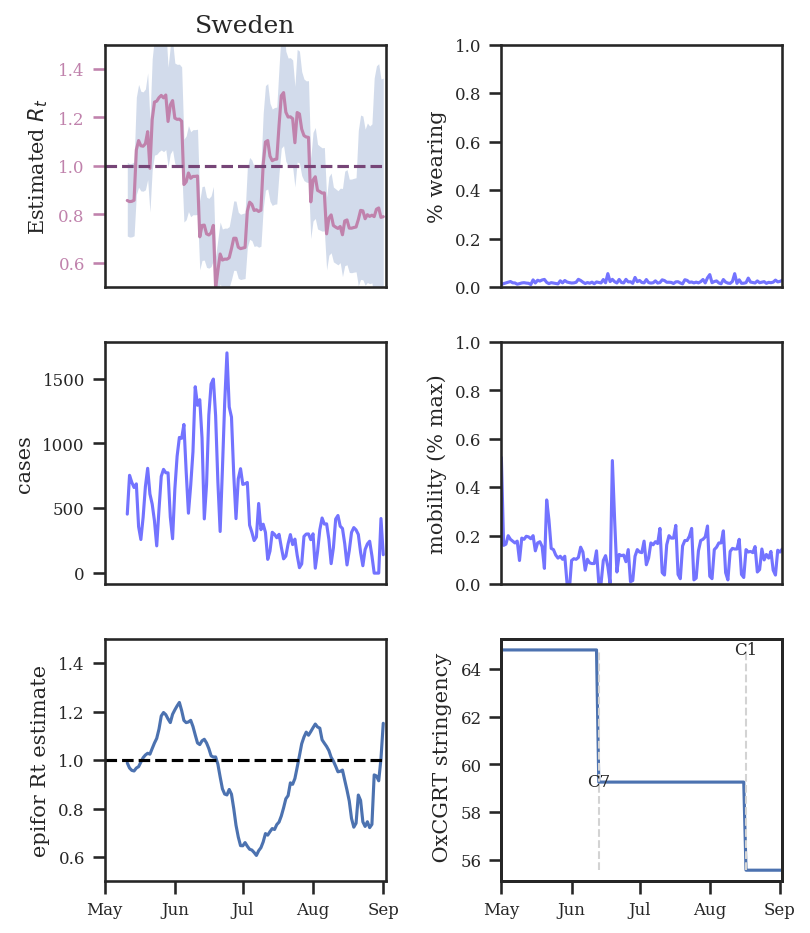

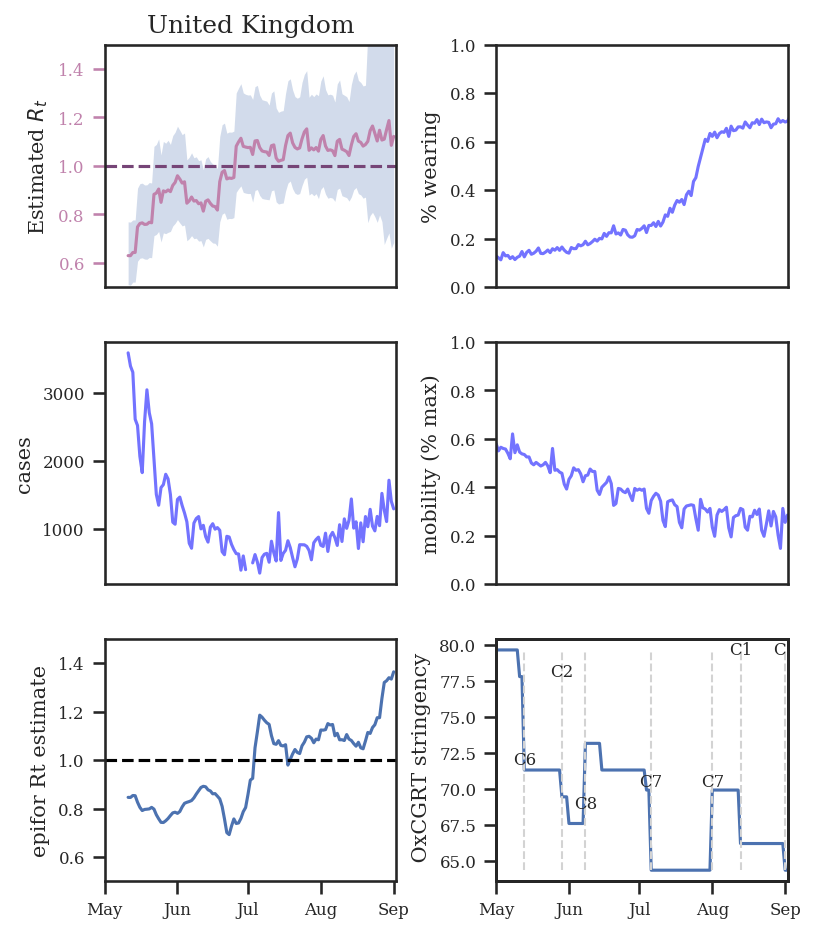

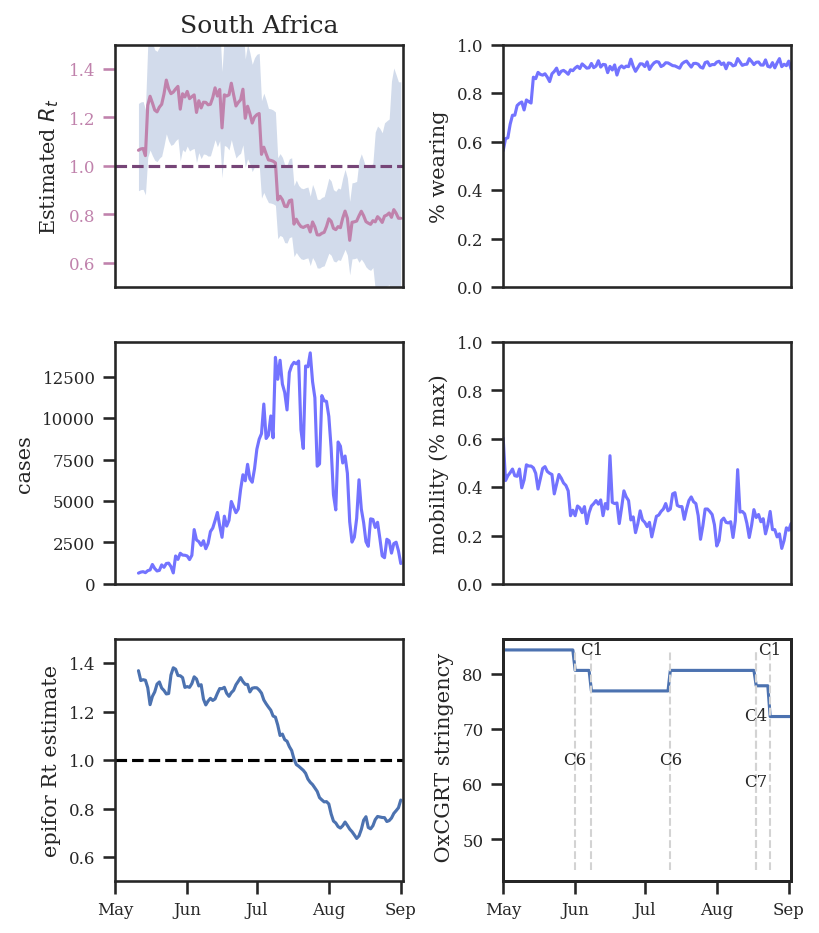

In [19]:
import imp
imp.reload(rp)

pred_rs = ["India", "Sweden", "United Kingdom", "South Africa"]
for r in pred_rs: #data.Rs :
    rp.reprod_plot(exp_trace, data, mobility_data, oxcgrt, third_party_rts, r, start_d_i=0) 
    #plt.show()
    plt.savefig(f"../outputs/region_plots_{r}.pdf", bbox_inches="tight")

# Mob vs Wearing

In [20]:
from scipy.stats import pearsonr

df = masks_object.df

# corrs = []
# for c in mobility_data.reset_index().country.unique() :
#     if c not in df.reset_index().country.unique() :
#         continue
    
#     mobc = mobility_data.loc[c]
#     cdf = df.loc[c]
#     j = cdf[["percent_mc"]].join(mobc.avg_mobility_no_parks_no_residential)
#     corr = np.corrcoef(j.avg_mobility_no_parks_no_residential, j.percent_mc)
#     if corr[0][1] != np.nan :
#         corrs.append(corr[0][1])

# corrs = [c for c in corrs if not np.isnan(c)]
#np.mean(corrs)

# print("rho (overall)", pearsonr(df.avg_mobility_no_parks_no_residential, df["percent_mc"]))

# Mandate vs wearing correlation

In [21]:
from scipy.stats import spearmanr
df = mobility_data

print("rho (binary overall)", spearmanr(df.percent_mc, df["H6_Facial Coverings"])[0])


# or original 4-level H6:
df2 = df.reset_index()
df2["date"] = pd.to_datetime(df2["date"])
df2 = df2[["country", "date", "percent_mc"]]
df2 = df2.set_index(["country", "date"])
ourox = oxcgrt[oxcgrt.CountryName.isin(data.Rs)][["CountryName", "date", "H6_Facial Coverings"]]
ourox.columns = ["country", "date", "H6_Facial Coverings"]
ourox = ourox.set_index(["country", "date"])
ourox = ourox.join(df2)

print("Original 4-level rho", spearmanr(ourox.percent_mc, ourox["H6_Facial Coverings"])[0] )

rho (binary overall) 0.3388289813800458
Original 4-level rho 0.4073579442387155


# Correlation with announcement shift

In [22]:
df = mobility_data

def get_mandate_switches(cdf):
    return cdf[cdf["H6_Facial Coverings"].diff() == 1]

def add_uniform_announcement_period(df, ANNOUNCE_LEAD = 5):
    df2 = df.copy().reset_index()
    announced = pd.DataFrame()

    for c in df2.country.unique():
        cdf = df2[df2.country == c]
        switch = get_mandate_switches(cdf)
        date = switch.head(1)["date"].any()
        if date:
            for i in range(1, ANNOUNCE_LEAD+1):
                d = pd.to_datetime(date) - timedelta(days=i)
                cdf.date = pd.to_datetime(cdf.date)
                cdf.loc[cdf["date"] == d, "H6_Facial Coverings"] = 1

            announced = pd.concat([announced, cdf])
    
    return spearmanr(announced.percent_mc, announced["H6_Facial Coverings"])[0]


five = add_uniform_announcement_period(df, ANNOUNCE_LEAD = 5)
ten = add_uniform_announcement_period(df, ANNOUNCE_LEAD = 10)

five, ten

(0.27503379584348453, 0.2595314602874418)

#

In [42]:
imp.reload(mw)
import epimodel.viz.mandate_wearing as mw

def post_mandate_rise(Rs, df, uk_separately=False):
    ranges = []
    
    if uk_separately:
        Rs, df = mw.add_uk_nations(Rs, df)
    
    d = mw.get_centred_summary(Rs, df)
    
    for c in d.country.unique() :
        last = d[(d.country == c) & (d.day > 21)]
        first = d[(d.country == c) & (d.day < 0)]
        if len(last) :
            last = last.percent_mc.mean()
            first = first.percent_mc.mean()
            ranges.append( last - first )
    
    return ranges

rises = post_mandate_rise(data.Rs, mobility_data, uk_separately=True)
piles = np.percentile(rises, [2.5, 50, 97.5])


# def exp_reduction_vector(a, x) :
#     reductions = 1 - np.exp((-1.0) * a * x)
#     return reductions

# #a = exp_trace.Wearing_Alpha.mean()
# #exp_reduction_vector(a, piles)

piles, np.std(rises)

/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(array([-0.00770289,  0.08627141,  0.49334813]), 0.14602469125012751)

# Fig .2

/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


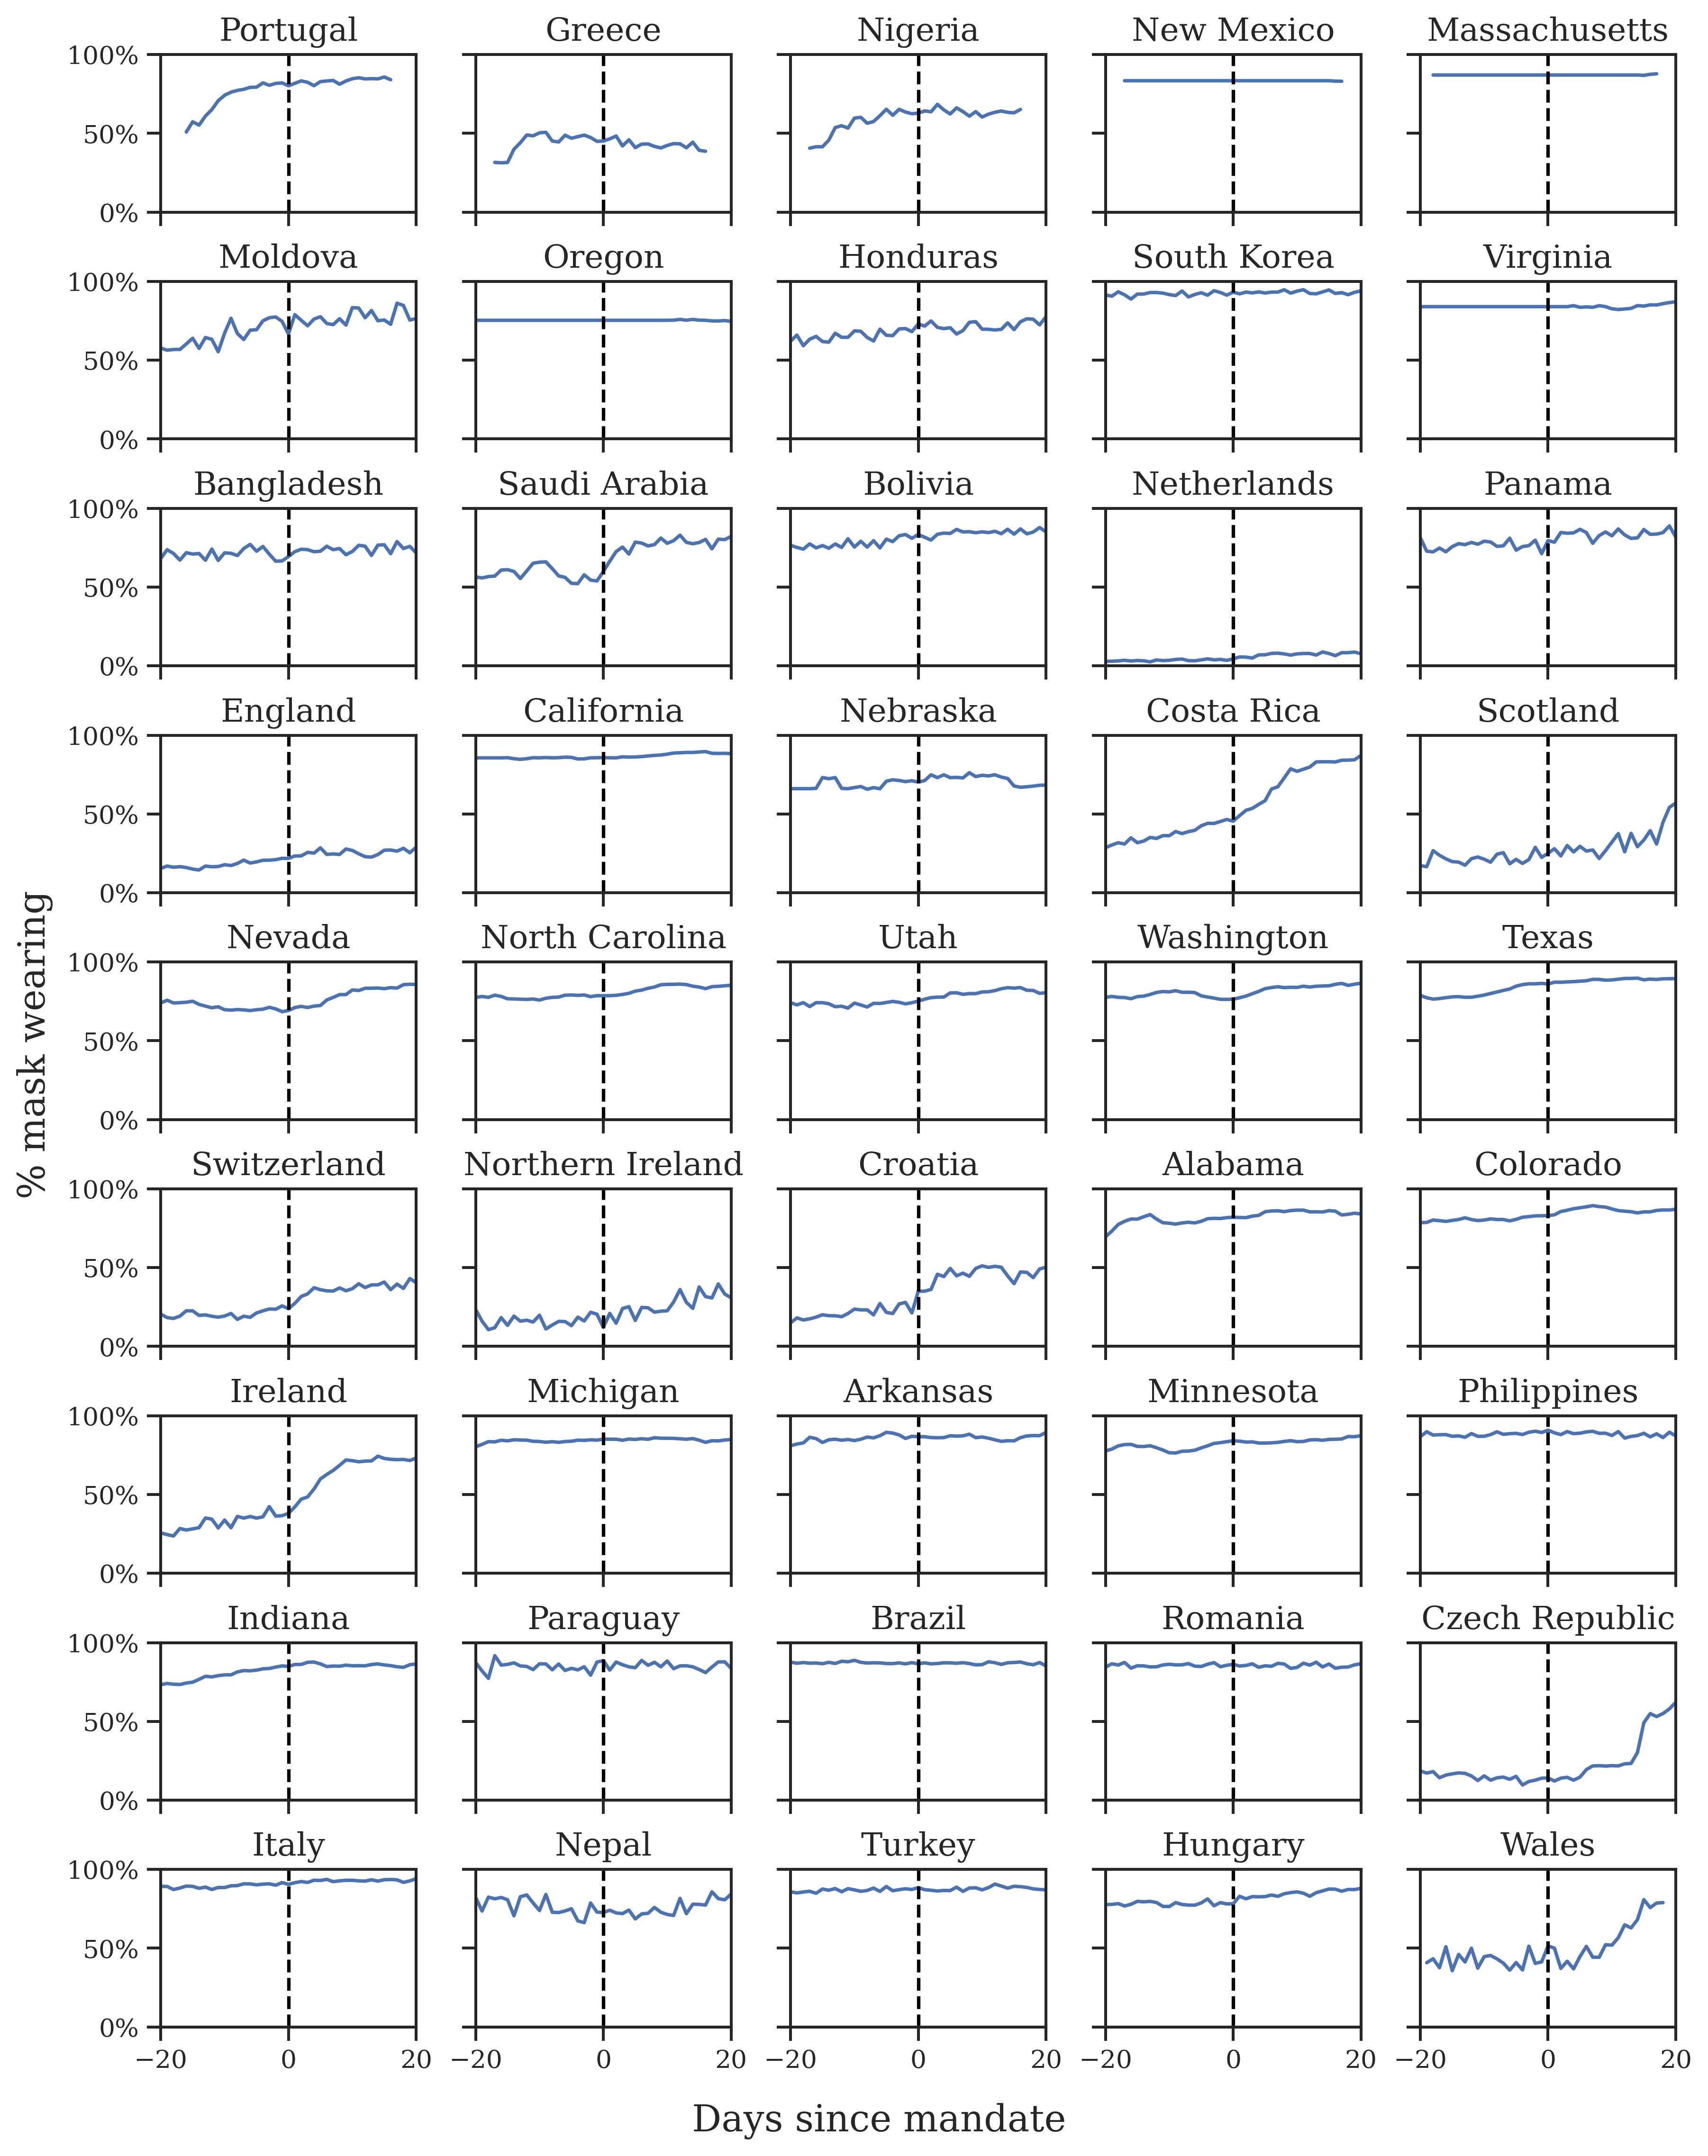

In [25]:
df = mobility_data

imp.reload(mw)

#mw.mandate_barplot(df)
#mw.mandate_distplot(df)
#mw.messy_centred_mandate_plot(data.Rs, df)
#mw.original_stringency_plot(ourox)
#mw.centred_mandate_plot(data.Rs, df)


mw.country_centred_mandate_plot(data.Rs, df)
plt.savefig("../outputs/mw_panels.pdf", bbox_inches="tight")



## Redo with 0 to 3+ switches

In [26]:
imp.reload(mw)

df = mobility_data

#mw_plot_Rs, mw_plot_df = data.Rs, df
mw_plot_Rs, mw_plot_df = mw.add_uk_nations(data.Rs, df)
mandate_rs_by_date = mw.get_mandates_by_date(mw_plot_Rs, mw_plot_df)
summaries = mw.get_centred_summary(mw_plot_Rs, mw_plot_df, col="H6_Facial Coverings_3plus")
strict_countries = summaries.country.unique()

df = df.reset_index()
strict_df = df[df.country.isin(strict_countries)]
spearmanr(strict_df.percent_mc, strict_df["H6_Facial Coverings_3plus"])[0]

/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


0.34091173625058396

/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


42

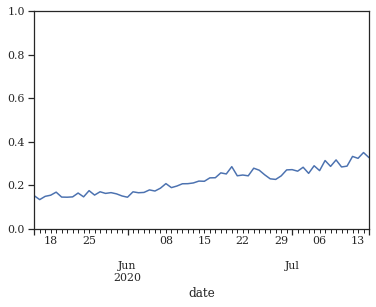

In [29]:
df = mobility_data
_, uk = mw.add_uk_nations(data.Rs, df)
uk = uk.reset_index()
uk.date = pd.to_datetime(uk.date)
#uk = uk[(uk.date < pd.to_datetime("2020-09-21")) & (uk.date > pd.to_datetime("2020-05-01"))]
uk = uk[(uk.date >= pd.to_datetime("2020-05-15")) & (uk.date <= pd.to_datetime("2020-07-15"))]

uk = uk.set_index(["country", "date"])
uk.loc["England"].percent_mc.plot()
plt.ylim(0,1)

#mw.get_mandate_switches(uk.loc["England"], col="H6_Facial Coverings")

#uk.loc["Scotland"].percent_mc.plot()
mw.get_mandate_switches(uk.loc["England"], col="H6_Facial Coverings_3plus")

e = uk.loc["England"]
e["H6_Facial Coverings_3plus"]


len(mw.get_mandates_by_date(data.Rs, df))

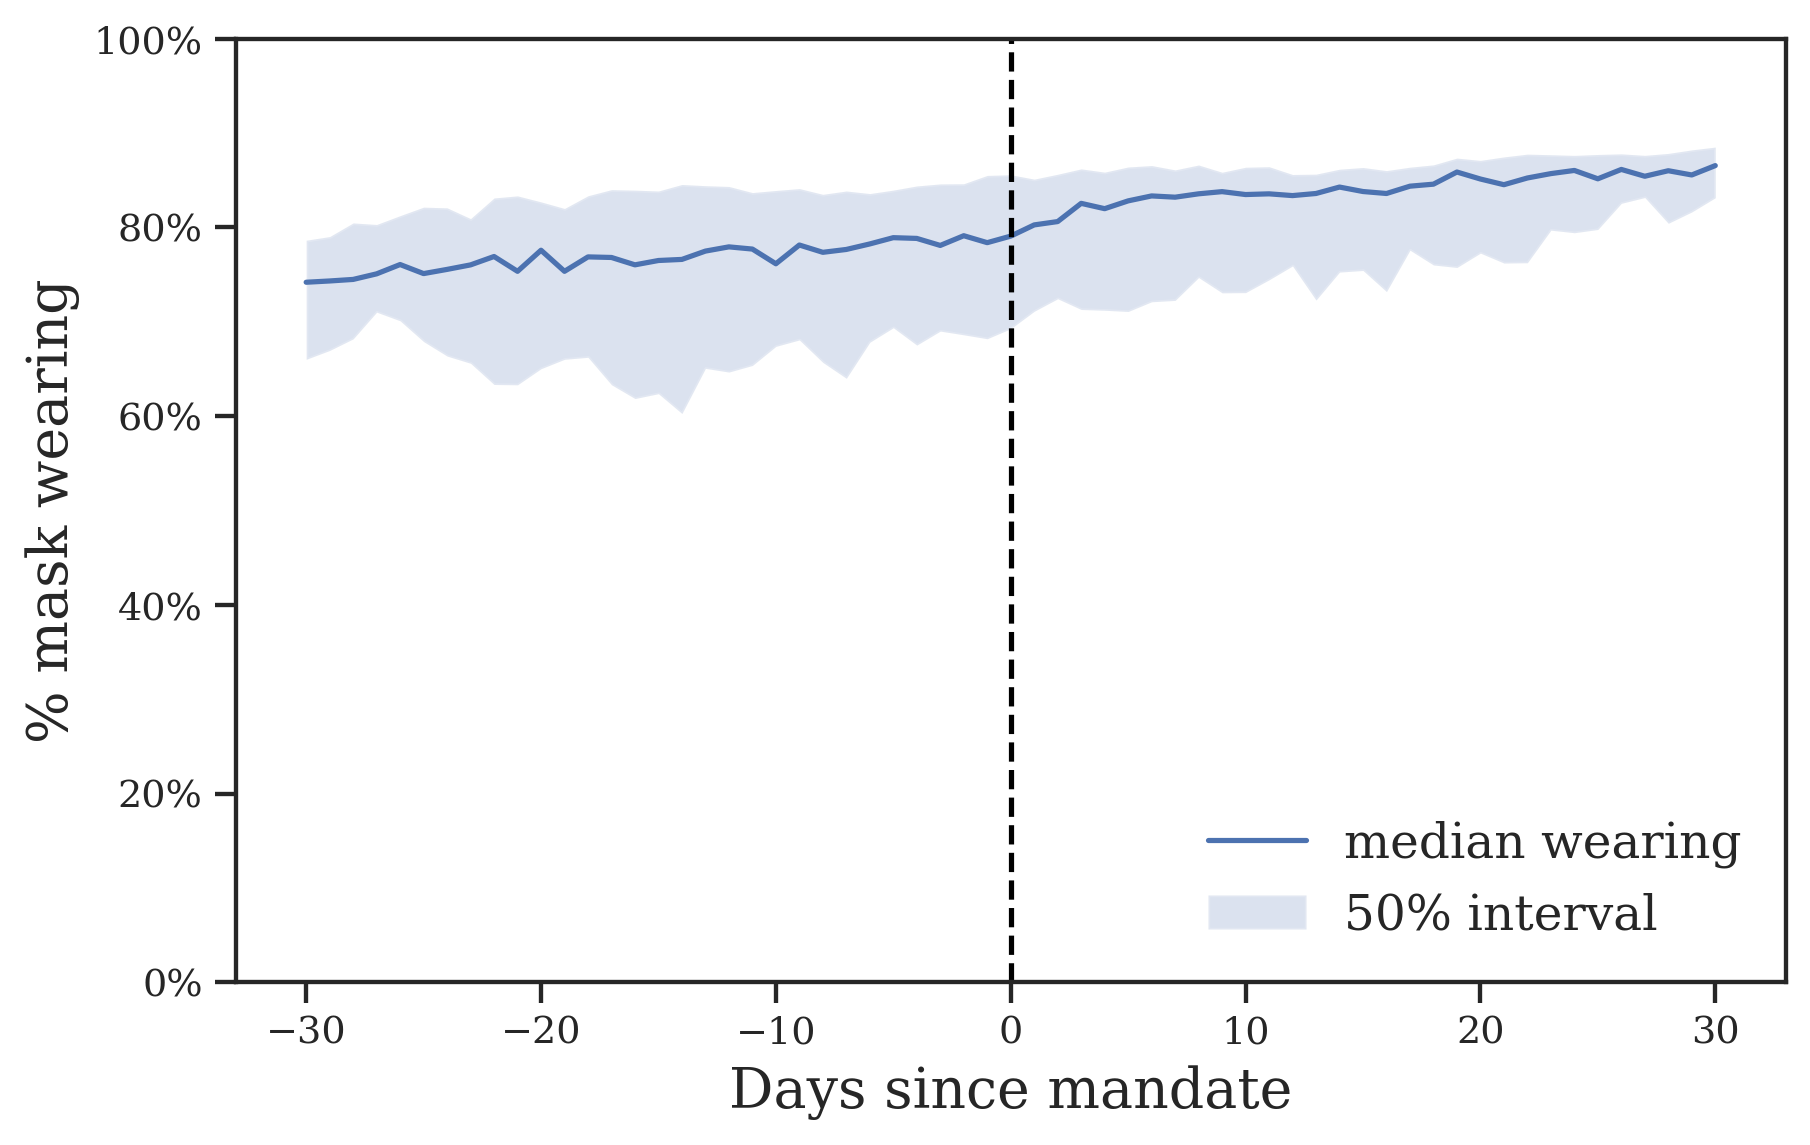

In [30]:
import imp
imp.reload(mw)

df = mobility_data
mw.centred_mandate_plot(data.Rs, df, uk_breakup=False)
#mw.centred_mandate_plot(data.Rs, df, uk_breakup=True)

plt.savefig("../outputs/average_wearing_under_mandates_ylim50.pdf", bbox_inches="tight")

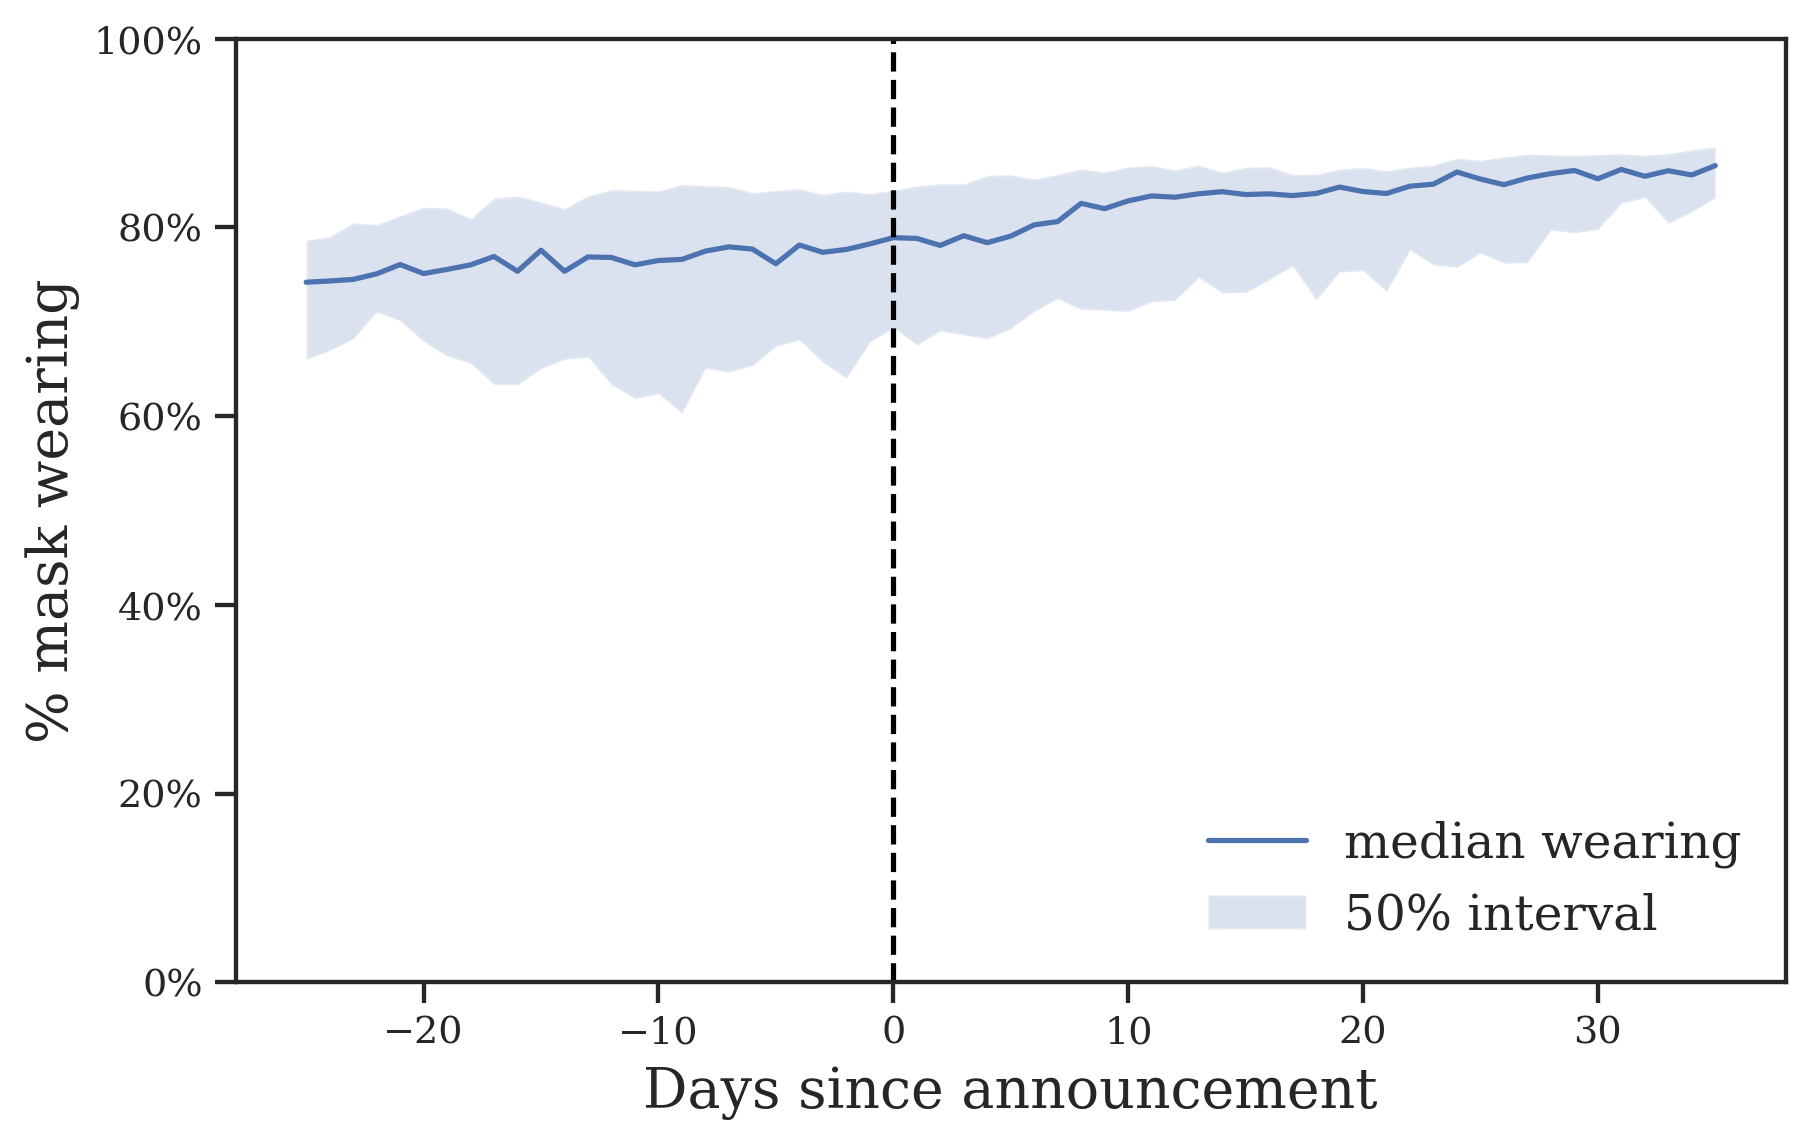

In [31]:
imp.reload(mw)
mw.centred_announcement_plot(data.Rs, df)



# Dumb F-test for mandate over time

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm

summaries = mw.get_centred_summary(data.Rs, df)
summaries = summaries.groupby("day").median() * 100
summaries = summaries.reset_index()
summaries["mandate"] = 0
summaries.loc[summaries.day > 0, "mandate"] = 1
summaries = summaries[summaries.day != 0]
lm1 = smf.ols(formula='percent_mc ~ day * mandate', data=summaries).fit()
print(lm1.summary())




In [ ]:
with open("../outputs/wearing_reduction_samples.txt", "r") as f :
    wred = f.read()
    wred = np.array(wred.split("\n")[:-1]).astype(np.float64)

with open("../outputs/mandate_reduction_samples.txt", "r") as f :
    mred = f.read()
    mred = np.array(mred.split("\n")[:-1]).astype(np.float64)

In [ ]:
np.median(wred)

# Fig 1: Posteriors

In [ ]:
# import imp
# imp.reload(rep)

# PNAS_WIDTH_INCHES = 3.4252
# fig, ax = plt.subplots(figsize=(PNAS_WIDTH_INCHES,PNAS_WIDTH_INCHES * 1.5), dpi=400)
# ax = plt.subplot(2,1,1)
# rep.main_result_posteriors(m=m_trace, w=exp_trace, ax=ax)
# plt.tight_layout()
# plt.subplots_adjust(top=1.3)
# plt.title("A", loc='left', fontweight="bold")

# df = mobility_data
# imp.reload(ew)
# ax = plt.subplot(2,1,2)
# plt.title("B", loc='left', fontweight="bold")
# ew.plot_median_wearing_effect(df, exp_trace, "exp", ax)

# plt.tight_layout()
# plt.savefig("../outputs/main_results_vertical.pdf")

# What is the empirical wearing in this window?

In [32]:
imp.reload(ew)

df = masks_object.df
Rs, uk_df = mw.add_uk_nations(data.Rs, df)

#ew.plot_actual_wearing_effect(df, exp_trace, "exp")
#ew.plot_max_wearing_effect(df, exp_trace, "exp", ax)

maxes = {c : uk_df.loc[c].percent_mc.max() \
         for c in uk_df.reset_index().country.unique()}

g = df.reset_index()[["country", "percent_mc"]].groupby("country")
ranges = g.max("percent_mc") - g.min("percent_mc")
print("Average change in wearing in window:", round(ranges.median().iloc[0], 3) )

/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Average change in wearing in window: 0.194


# Fig 3: R reduction over wearing

NameError: name 'q2_trace' is not defined

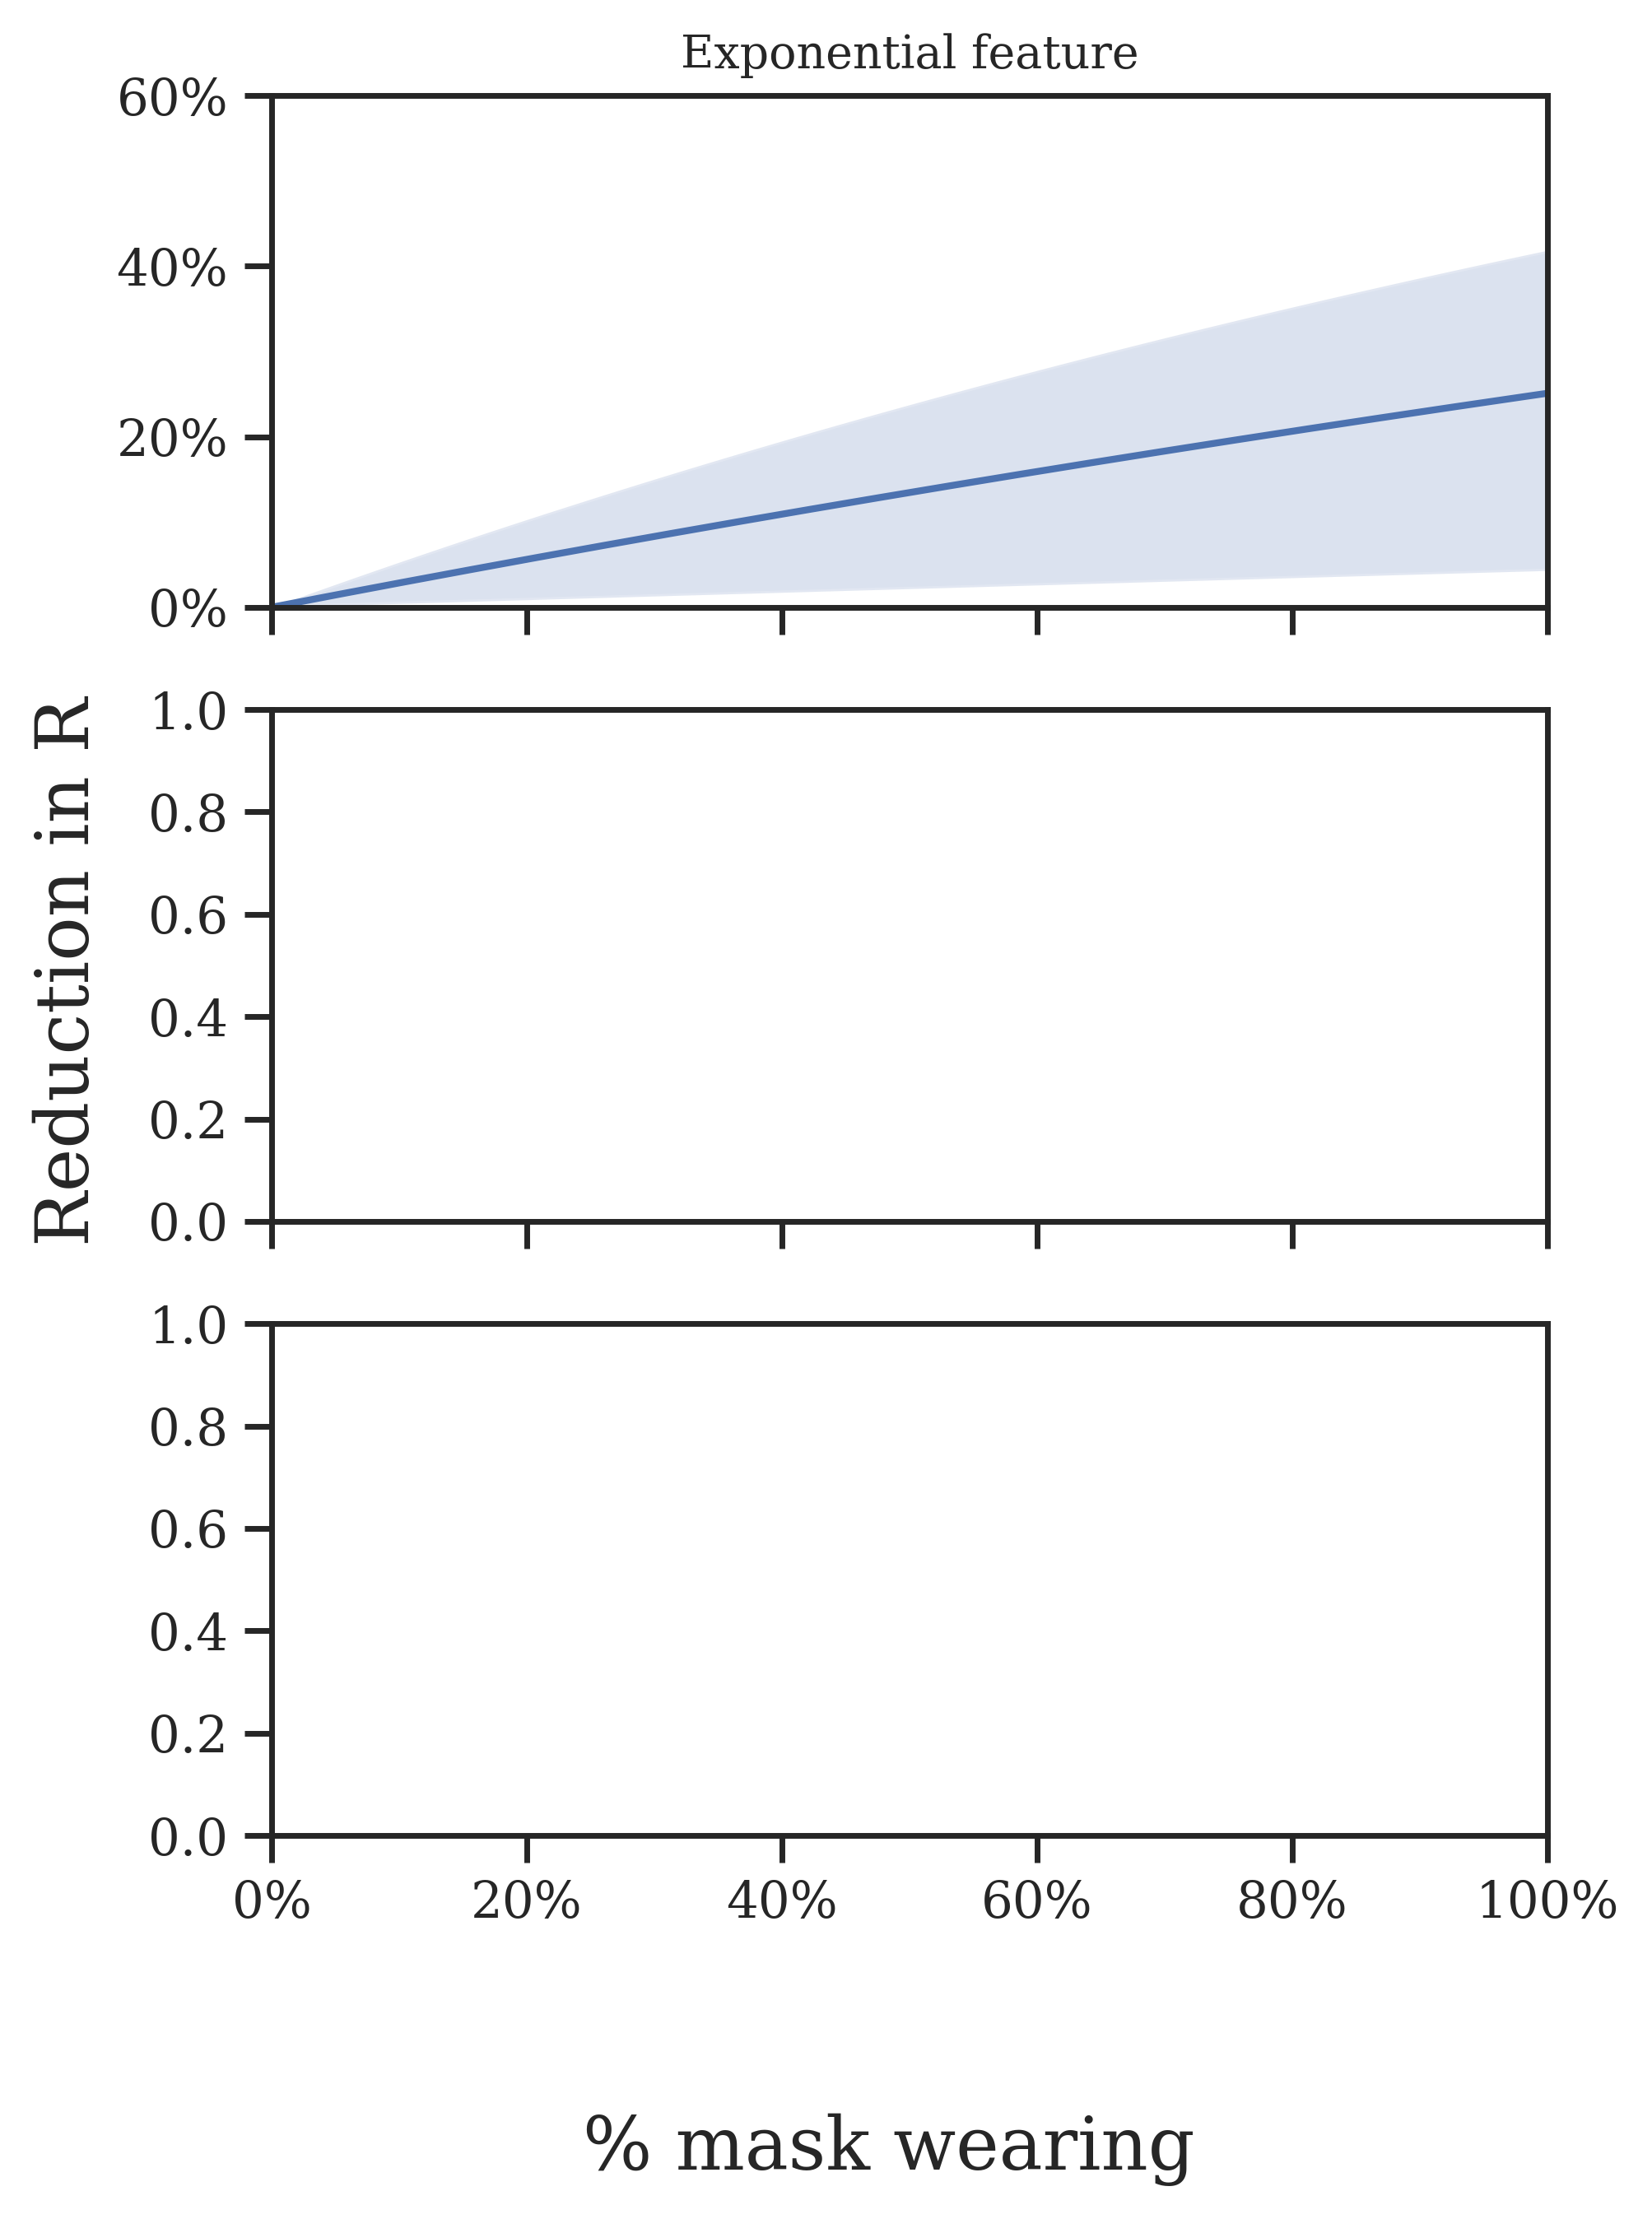

In [33]:
def exp_reduction_vector(a, x) :
    reductions = 1 - np.exp((-1.0) * a * x)
    return reductions

def relu(x):
    return np.maximum(0, x)

def ll_reduction_vector(a, x) :
    w = a * x 
    reductions = - np.log(relu(1 - w))
    return reductions


def q2_reduction_vector(alphas, x) :
    w = alphas[0] * x + alphas[1] * x**2
    reductions = - np.log(relu(1 - w))
    return reductions


def plot_param(tr, r, t, ax):
    alpha = tr.Wearing_Alpha.mean()
    
    if tr.Wearing_Alpha.shape[1] > 1 :
        lu0, m0, hi0 = np.percentile(tr.Wearing_Alpha[0], [2.5, 50, 97.5])
        lu1, m1, hi1 = np.percentile(tr.Wearing_Alpha[1], [2.5, 50, 97.5])
        alpha = [m0, m1]
        lu = [lu0, lu1]
        hi = [hi0, hi1]
    else:
        lu, alpha, hi = np.percentile(tr.Wearing_Alpha, [2.5, 50, 97.5])
    
    i = data.CMs.index("percent_mc")
    x = np.linspace(0, 1, 1000)
    y = r(alpha, x)
    
    #plt.plot(x, y)
    ax.plot(x * 100, y * 100)
    
    los = r(lu, x) 
    his = r(hi, x)
    ax.fill_between(x * 100, los * 100, his * 100, alpha=0.2)
    
    ax.set_title(t, fontsize=10)
    ax.set_ylim(0,60)
    ax.set_xlim(0,100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

f, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5,7), dpi=400)
plot_param(exp_trace, exp_reduction_vector, "Exponential feature", ax1)
#plt.set_ylabel("", fontsize=16)
f.text(0.5, -0.02, '% mask wearing', ha='center', fontsize=16)
f.text(-0.02, 0.5, "Reduction in R", va='center', fontsize=16, rotation='vertical')

plot_param(q2_trace, q2_reduction_vector, "Quadratic feature", ax2)
plot_param(ll_trace, ll_reduction_vector, "Linear feature", ax3)
plt.tight_layout()
plt.savefig("../outputs/wearing_paramets.pdf", bbox_inches='tight')

# YOUGOV: Max mandate effect on wearing in first wave

Avg uptake at year start: 32.7
Avg uptake just before announcement: 64.2
Avg uptake after mandate: 75.2


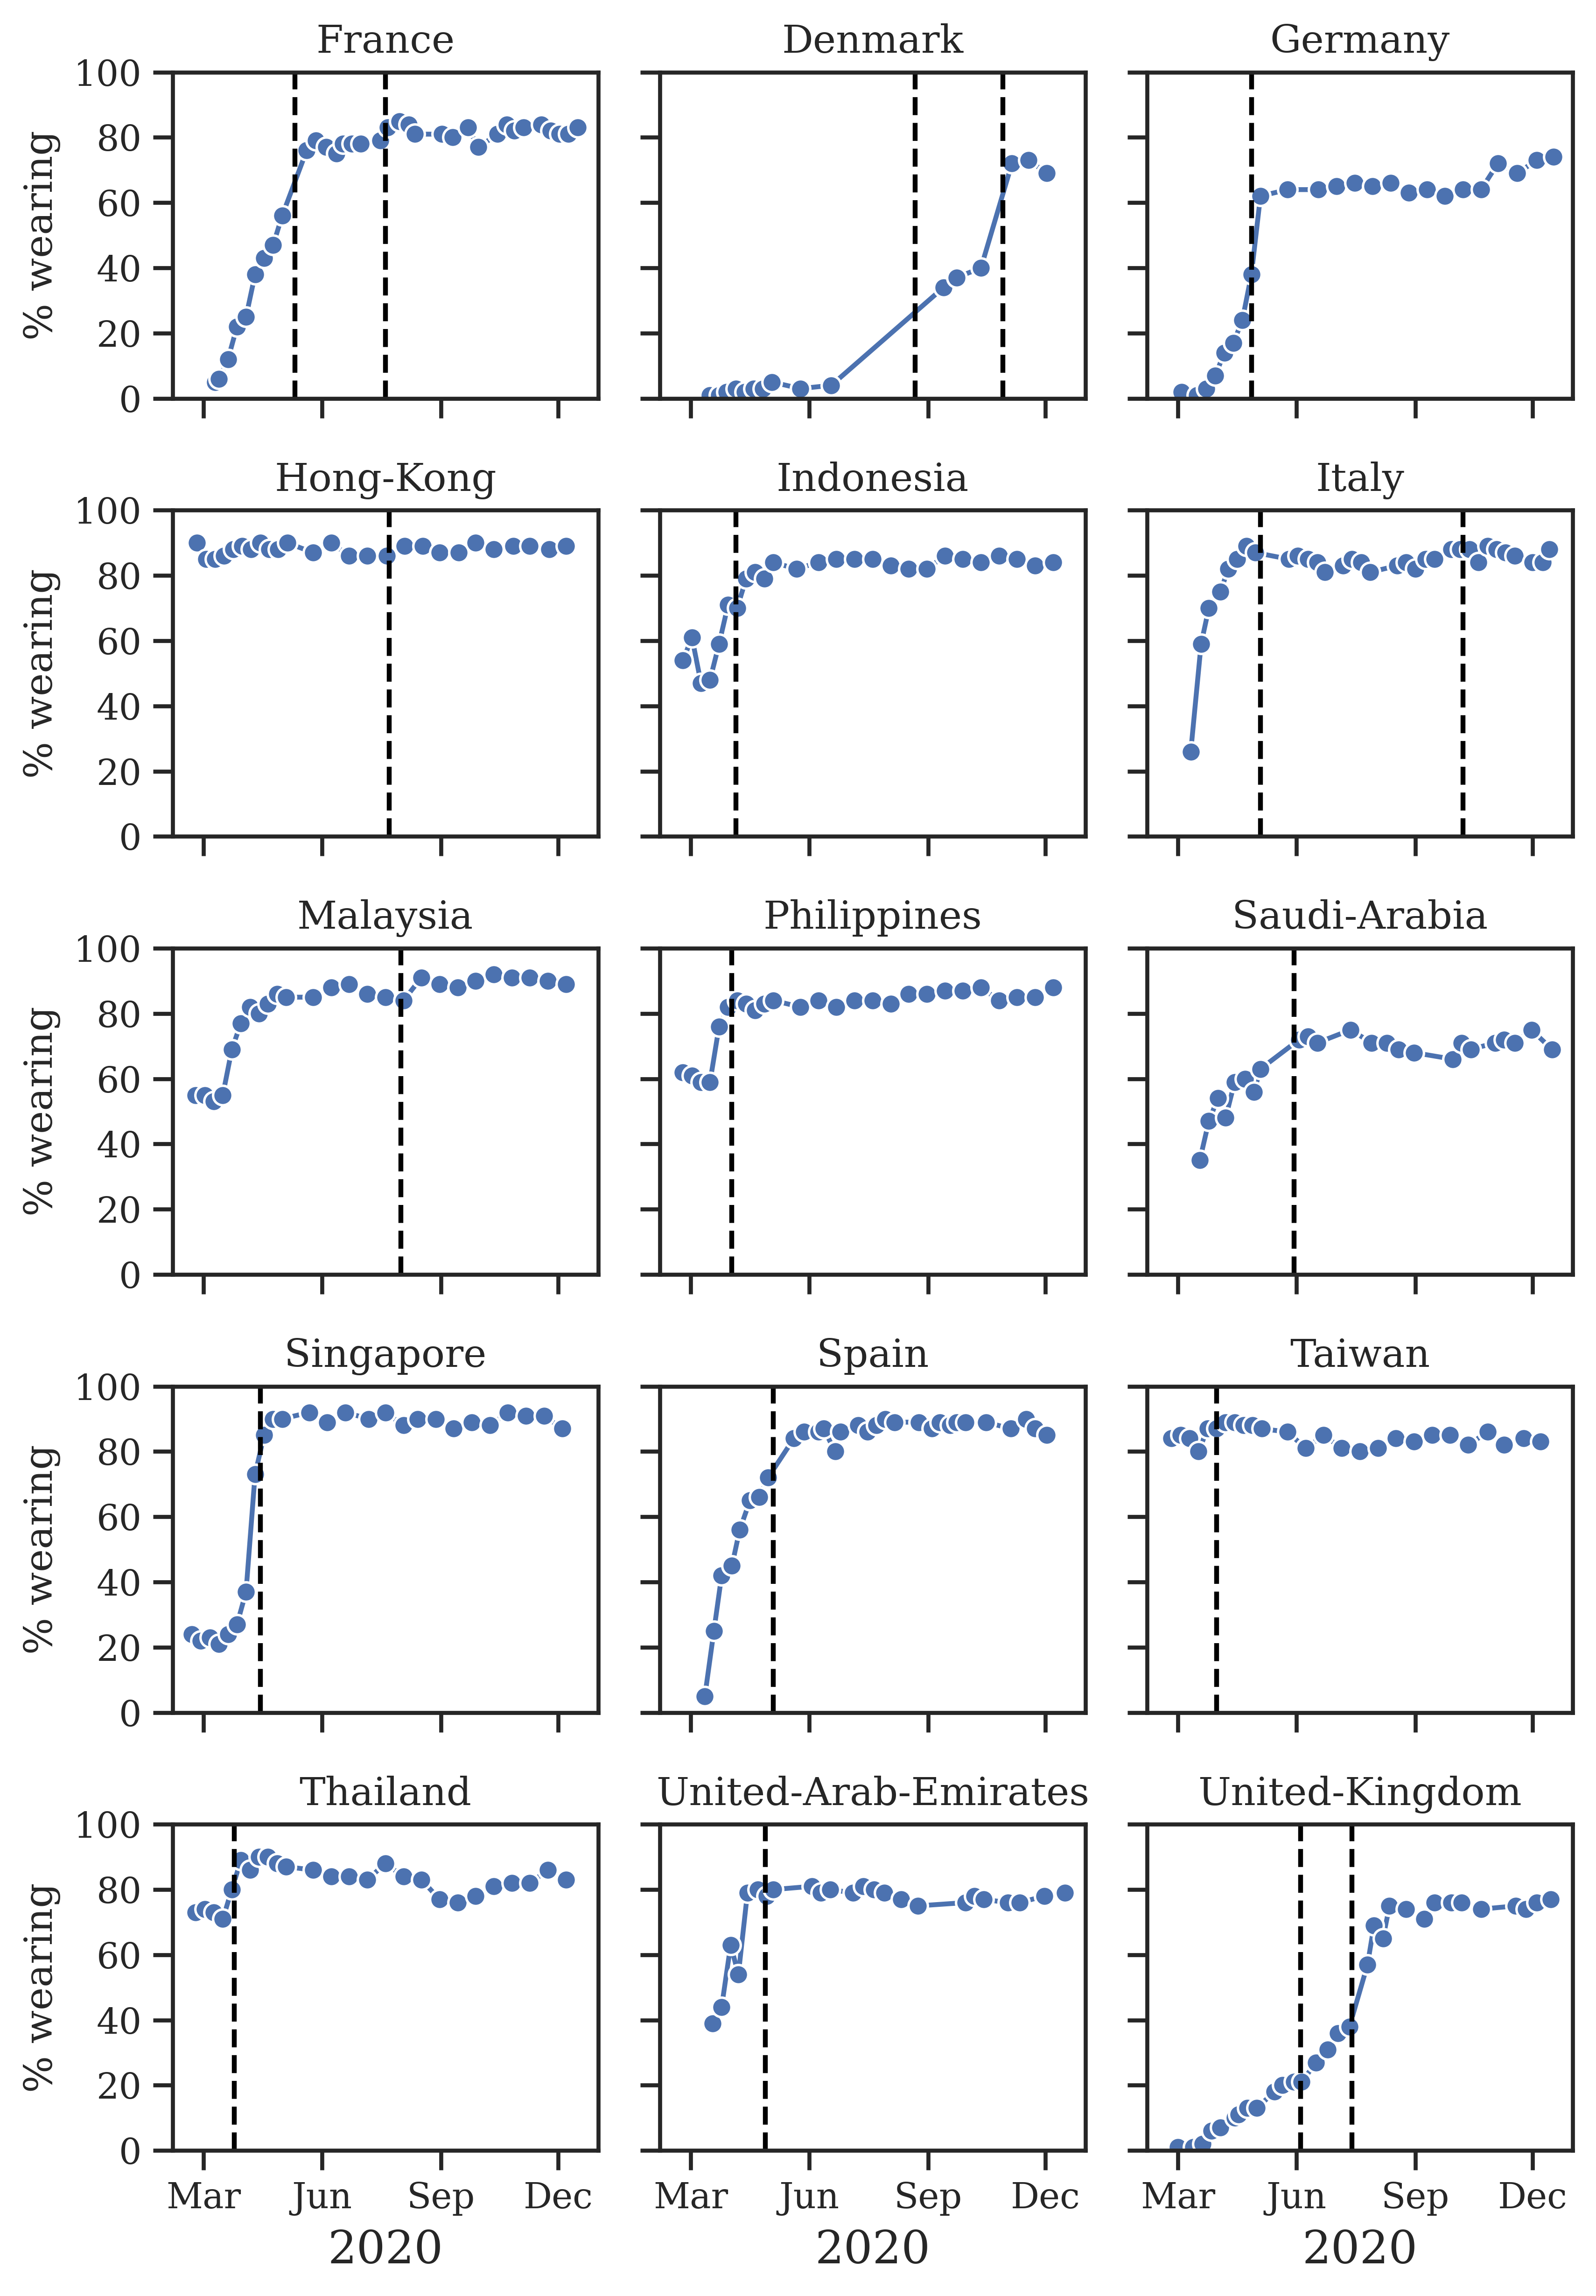

In [34]:
import imp
imp.reload(yg)


yg.plot_earliest_mandates_against_wearing()

yg.get_before_after_mandate_change()


plt.savefig("../outputs/yg_first_wave.pdf", bbox_inches='tight')

# Posterior correlations

In [ ]:
sns.set(style="ticks", font='DejaVu Serif', font_scale=0.3)


def post_alpha_corrs(tr, w, ax):
    if w == "Wearing":
        m = "WearingReduction"
    else :
        m = "MandateReduction"
    df_exp = pm.trace_to_dataframe(tr, varnames = ['CMReduction', m, 'MobilityReduction'])

    df_exp.columns = npi_cols[:-2] + [m, "mobility"]
    corrs = df_exp.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corrs,
        mask=mask,
        #cmap=cmap,
        #vmax=1,
        linewidths=0.5,
        annot=True,
        fmt=".2f",
        vmin=-1, 
        vmax=1,
        center=0,
        cbar=False,
        ax=ax,
    );
    #ax.set_ylim(0, -1)
    #ax.yaxis.get_major_ticks()[0].label.visible = False
    ax.axes.get_xticklabels()[0].set_visible(False)
    
    

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.5, 7), dpi=700)

short_labels = ["School 2+",
 "School 3+",
 "Work 2+",
 "Work 3+",
 "Gatherings 3+",
 "Stay at home",
 "internal movement",
 "Gatherings 2+",
 "Gatherings 4+",
 "WearingReduction",
 "mobility"]

post_alpha_corrs(exp_trace, w="Wearing", ax=ax1)
ax1.set_title(f"Wearing model, posterior correlations in reductions", fontsize=6)
ax1.set_yticklabels(short_labels)
ax1.set_xticklabels(short_labels)

post_alpha_corrs(m_trace, w="Mandate", ax=ax2)
ax2.set_title(f"\n\nMandate model, posterior correlations in reductions", fontsize=6)
ax2.set_yticklabels(short_labels)
ax2.set_xticklabels(short_labels)

f.subplots_adjust(hspace=20)
plt.tight_layout()



plt.savefig("../outputs/posterior_corrs.pdf", bbox_inches='tight')


# Holdout nonwearers

In [35]:
y.iloc[-7:-1].mean()

y = wearing[["percent_mc", "country"]].groupby("country").max()
#plt.bar(y.index, y.percent_mc)
y.sort_values("percent_mc")

y.mean()

NameError: name 'y' is not defined

# How many NPIs are active at the start? Which are "reopening"?

In [36]:
#df = df.reset_index()
start_df = df[df.date == "2020-05-01"]
npis = [c for c in df.columns[4:15]]


ps = []
for npi in npis:
    pct_1 = start_df[npi].value_counts(normalize=True).loc[1]
    print(npi, f"{pct_1:.1f}")
    ps.append(pct_1)
    
np.mean([0.9, 0.8, 0.6, 0.5, 0.8])


AttributeError: 'DataFrame' object has no attribute 'date'